# Imports:

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats.stats import pearsonr, ttest_ind
from os.path import join, sep
import config as c
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

# Set some important variables:

In [2]:
valid_users = c.valid_users
watch_acc_base = c.watch_acc_baseline
phone_acc_base = c.phone_acc_baseline
statistics = ['median', 'mean', np.std]
min_val = c.report_values[0]
max_val = c.report_values[-1]

In [5]:
trim_dict = {'TUaG': {'start':2, 'end':2},
             'Sit relaxed': {'start':2, 'end':0},
             'Sit extended': {'start':2, 'end':0},
             'Stand': {'start':2, 'end':0},
             'Walk': {'start':2, 'end':2},
             'Drink': {'start':2, 'end':2},
             'Rotate hands': {'start':2, 'end':0}
            }

# Set working environment:

In [3]:
cloud = False
if cloud:
    data_path = c.cloud_data_path
else:
    data_path = c.data_path

# Read Data:

In [4]:
clinic_assessments_watch_acc_df = pd.read_pickle(c.clinic_assessments_watch_acc_pkl_file_path)
clinic_assessments_watch_acc_df.name = 'clinic_assessments_watch_acc'

clinic_steps_watch_acc_df = pd.read_pickle(c.clinic_steps_watch_acc_pkl_file_path)
clinic_steps_watch_acc_df.name = 'clinic_steps_watch_acc'

home_assessments_watch_acc_df = pd.read_pickle(c.home_assessments_watch_acc_pkl_file_path)
home_assessments_watch_acc_df.name = 'home_assessments_watch_acc'

home_steps_watch_acc_df = pd.read_pickle(c.home_steps_watch_acc_pkl_file_path)
home_steps_watch_acc_df.name = 'home_steps_watch_acc'

home_reminders_watch_acc_df = pd.read_pickle(c.home_reminders_watch_acc_pkl_file_path)
home_reminders_watch_acc_df.name = 'home_reminders_watch_acc'

clinic_steps_phone_acc_df = pd.read_pickle(c.clinic_steps_phone_acc_pkl_file_path)
clinic_steps_phone_acc_df.name = 'clinic_steps_phone_acc'

home_steps_phone_acc_df = pd.read_pickle(c.home_steps_phone_acc_pkl_file_path)
home_steps_phone_acc_df.name = 'home_steps_phone_acc'

In [12]:
def trim_assessment_per_step(assess_df, trim_dict, samples_freq=50):
    sorted_assess_df = assess_df.sort_values(by='timestamp', ascending=True)
    steps_list = assess_df['step_name'].unique()
    trimmed_df = pd.DataFrame()
    for step in steps_list:
        step_df = sorted_assess_df[sorted_assess_df['step_name']==step]
        trim_start_sec = trim_dict[step]['start']
        trim_start_samp = trim_start_sec*samples_freq
        trim_end_sec = trim_dict[step]['end']
        if trim_end_sec != 0:
            trim_end_samp = -(trim_end_sec*samples_freq)
        else:
            trim_end_samp = step_df.shape[0]
        trimmed_step = step_df.iloc[trim_start_samp:trim_end_samp]
        trimmed_df = pd.concat([trimmed_df, trimmed_step])
    return trimmed_df

In [13]:
def trim_entire_df_per_step(df, trim_dict, samsamples_freq=50):
    sorted_df = df.sort_values(by='timestamp', ascending=True)
    assessments_list = df['assessment_id'].unique()
    trimmed_entire_df = pd.DataFrame()
    for assess in assessments_list:
        assess_df = sorted_df[sorted_df['assessment_id']==assess]
        trimmed_assess = trim_assessment_per_step(assess_df, trim_dict)
        trimmed_entire_df = pd.concat([trimmed_entire_df, trimmed_assess])
    return trimmed_entire_df

## Check which users appear in which datasets:

In [5]:
print(sorted(clinic_assessments_watch_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(clinic_steps_watch_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(home_assessments_watch_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(home_steps_watch_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(home_reminders_watch_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(clinic_steps_phone_acc_df.user_id.unique().astype(int).tolist()))
print(sorted(home_steps_phone_acc_df.user_id.unique().astype(int).tolist()))

[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]
[8, 25, 45, 51, 57, 63, 74, 82, 94, 108]


## Present reports from the lab, per assessment:

In [7]:
clinic_assessments_watch_acc_df[['user_id', 'assessment_id', 'patient_report_value', 'clinician_report_value']].\
groupby(['user_id', 'assessment_id'], as_index=False).agg('mean').head(15)

user_id  assessment_id  patient_report_value  clinician_report_value
0         8  1490640580656                   1.0                     2.0
1        25  1487605701264                   1.0                     2.0
2        25  1493912424448                   0.0                     2.0
3        45  1490637319938                   2.0                     3.0
4        51  1490284781631                   3.0                     2.0
5        57  1481923232988                   1.0                     2.0
6        63  1493920652116                   0.0                     2.0
7        74  1485546321147                   2.0                     2.0
8        82  1489765988342                   3.0                     4.0
9        94  1493741957038                   3.0                     2.0
10      108  1488396181636                   0.0                     2.0

# Raw accelerometer data analysis:

In [14]:
clinic_steps_watch_acc_df['acc_norm'] = np.sqrt((clinic_steps_watch_acc_df.x)**2 +\
                                                (clinic_steps_watch_acc_df.y)**2 +\
                                                (clinic_steps_watch_acc_df.z)**2)
clinic_steps_watch_acc_df['acc_abs_delta'] = abs(clinic_steps_watch_acc_df['acc_norm']-watch_acc_base)


home_steps_watch_acc_df['acc_norm'] = np.sqrt((home_steps_watch_acc_df.x)**2 +\
                                              (home_steps_watch_acc_df.y)**2 +\
                                              (home_steps_watch_acc_df.z)**2)
home_steps_watch_acc_df['acc_abs_delta'] = abs(home_steps_watch_acc_df['acc_norm']-watch_acc_base)


home_reminders_watch_acc_df['acc_norm'] = np.sqrt((home_reminders_watch_acc_df.x)**2 +\
                                                  (home_reminders_watch_acc_df.y)**2 +\
                                                  (home_reminders_watch_acc_df.z)**2)
home_reminders_watch_acc_df['acc_abs_delta'] = abs(home_reminders_watch_acc_df['acc_norm']-watch_acc_base)


clinic_steps_phone_acc_df['acc_norm'] = np.sqrt((clinic_steps_phone_acc_df.x)**2 +\
                                                (clinic_steps_phone_acc_df.y)**2 +\
                                                (clinic_steps_phone_acc_df.z)**2)
clinic_steps_phone_acc_df['acc_abs_delta'] = abs(clinic_steps_phone_acc_df['acc_norm']-phone_acc_base)


home_steps_phone_acc_df['acc_norm'] = np.sqrt((home_steps_phone_acc_df.x)**2 +\
                                              (home_steps_phone_acc_df.y)**2 +\
                                              (home_steps_phone_acc_df.z)**2)
home_steps_phone_acc_df['acc_abs_delta'] = abs(home_steps_phone_acc_df['acc_norm']-phone_acc_base)

In [ ]:
trimmed_clinic_steps_watch_acc = trim_entire_df_per_step(clinic_steps_watch_acc_df, trim_dict)
trimmed_clinic_steps_watch_acc.name = 'trimmed_clinic_steps_watch_acc'

trimmed_clinic_steps_phone_acc = trim_entire_df_per_step(clinic_steps_phone_acc_df, trim_dict)
trimmed_clinic_steps_phone_acc.name = 'trimmed_clinic_steps_phone_acc'

trimmed_home_steps_watch_acc = trim_entire_df_per_step(home_steps_watch_acc_df, trim_dict)
trimmed_home_steps_watch_acc.name = 'trimmed_home_steps_watch_acc'

trimmed_home_steps_phone_acc = trim_entire_df_per_step(home_steps_phone_acc_df, trim_dict)
trimmed_home_steps_phone_acc.name = 'trimmed_home_steps_phone_acc'

In [ ]:
clinic_watch_per_patient_step_mean_norm = clinic_steps_watch_acc_df[['user_id', 'step_name', 'acc_norm']]\
                                          .groupby(['user_id', 'step_name'], as_index=False).agg('mean')
clinic_steps_watch_acc_w_base = clinic_steps_watch_acc_df.merge(right=clinic_watch_per_patient_step_mean_norm,
                                                                how='inner',
                                                                on=['user_id', 'step_name'],
                                                                suffixes=['', '_mean'])
clinic_steps_watch_acc_w_base.name = 'clinic_steps_watch_acc_with_user_baseline'
clinic_steps_watch_acc_w_base['acc_abs_delta_user_bl'] = abs(clinic_steps_watch_acc_w_base['acc_norm']-\
                                                             clinic_steps_watch_acc_w_base['acc_norm_mean'])


trimmed_clinic_watch_per_patient_step_mean_norm = trimmed_clinic_steps_watch_acc[['user_id', 'step_name', 'acc_norm']]\
                                                  .groupby(['user_id', 'step_name'], as_index=False).agg('mean')
trimmed_clinic_steps_watch_acc_w_base = trimmed_clinic_steps_watch_acc.merge(right=trimmed_clinic_watch_per_patient_step_mean_norm,
                                                                             how='inner',
                                                                             on=['user_id', 'step_name'],
                                                                             suffixes=['', '_mean'])
trimmed_clinic_steps_watch_acc_w_base.name = 'trimmed_clinic_steps_watch_acc_with_user_baseline'
trimmed_clinic_steps_watch_acc_w_base['acc_abs_delta_user_bl'] = abs(trimmed_clinic_steps_watch_acc_w_base['acc_norm']-\
                                                             trimmed_clinic_steps_watch_acc_w_base['acc_norm_mean'])


home_watch_per_patient_step_mean_norm = home_steps_watch_acc_df[['user_id', 'step_name', 'acc_norm']]\
                                        .groupby(['user_id', 'step_name'], as_index=False).agg('mean')
home_steps_watch_acc_w_base = home_steps_watch_acc_df.merge(right=home_watch_per_patient_step_mean_norm,
                                                            how='inner',
                                                            on=['user_id', 'step_name'],
                                                            suffixes=['', '_mean'])
home_steps_watch_acc_w_base.name = 'home_steps_watch_acc_with_user_baseline'
home_steps_watch_acc_w_base['acc_abs_delta_user_bl'] = abs(home_steps_watch_acc_w_base['acc_norm']-\
                                                           home_steps_watch_acc_w_base['acc_norm_mean'])


trimmed_home_watch_per_patient_step_mean_norm = trimmed_home_steps_watch_acc[['user_id', 'step_name', 'acc_norm']]\
                                                  .groupby(['user_id', 'step_name'], as_index=False).agg('mean')
trimmed_home_steps_watch_acc_w_base = trimmed_home_steps_watch_acc.merge(right=trimmed_home_watch_per_patient_step_mean_norm,
                                                                             how='inner',
                                                                             on=['user_id', 'step_name'],
                                                                             suffixes=['', '_mean'])
trimmed_home_steps_watch_acc_w_base.name = 'trimmed_home_steps_watch_acc_with_user_baseline'
trimmed_home_steps_watch_acc_w_base['acc_abs_delta_user_bl'] = abs(trimmed_home_steps_watch_acc_w_base['acc_norm']-\
                                                             trimmed_home_steps_watch_acc_w_base['acc_norm_mean'])
                                                             

clinic_phone_per_patient_step_mean_norm = clinic_steps_phone_acc_df[['user_id', 'step_name', 'acc_norm']]\
                                          .groupby(['user_id', 'step_name'], as_index=False).agg('mean')
clinic_steps_phone_acc_w_base = clinic_steps_phone_acc_df.merge(right=clinic_phone_per_patient_step_mean_norm,
                                                                how='inner',
                                                                on=['user_id', 'step_name'],
                                                                suffixes=['', '_mean'])
clinic_steps_phone_acc_w_base.name = 'clinic_steps_phone_acc_with_user_baseline'
clinic_steps_phone_acc_w_base['acc_abs_delta_user_bl'] = abs(clinic_steps_phone_acc_w_base['acc_norm']-\
                                                             clinic_steps_phone_acc_w_base['acc_norm_mean'])

### Inspect the per patient distribution of the accelerometer norm, for step "Sit relaxed":

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025502BC7A20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000025506FADF28>]], dtype=object)

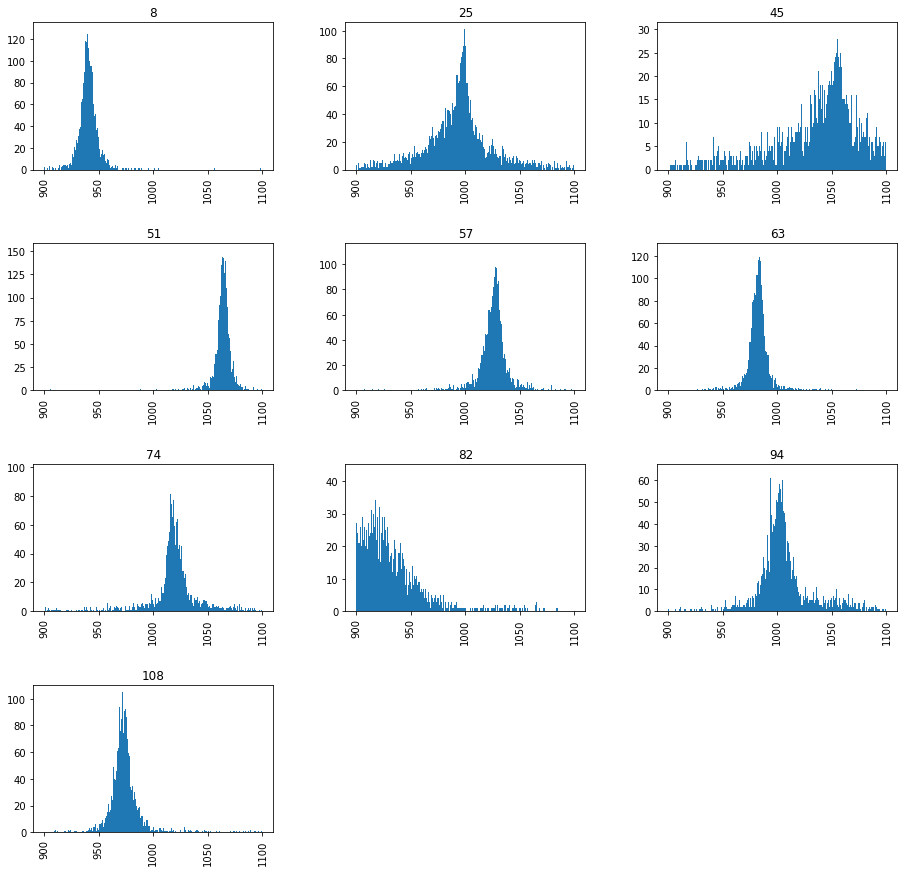

In [213]:
clinic_steps_watch_sit = clinic_steps_watch_acc_df[['user_id', 'acc_norm']]\
                           [clinic_steps_watch_acc_df.step_name=='Sit relaxed']
clinic_steps_watch_sit['acc_norm'].hist(by=clinic_steps_watch_sit['user_id'], figsize=(15,15),
                                           bins=700, range=(900, 1100))

### And for the entire data (without specifying a step):

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000253A39723C8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000253A745AE10>]], dtype=object)

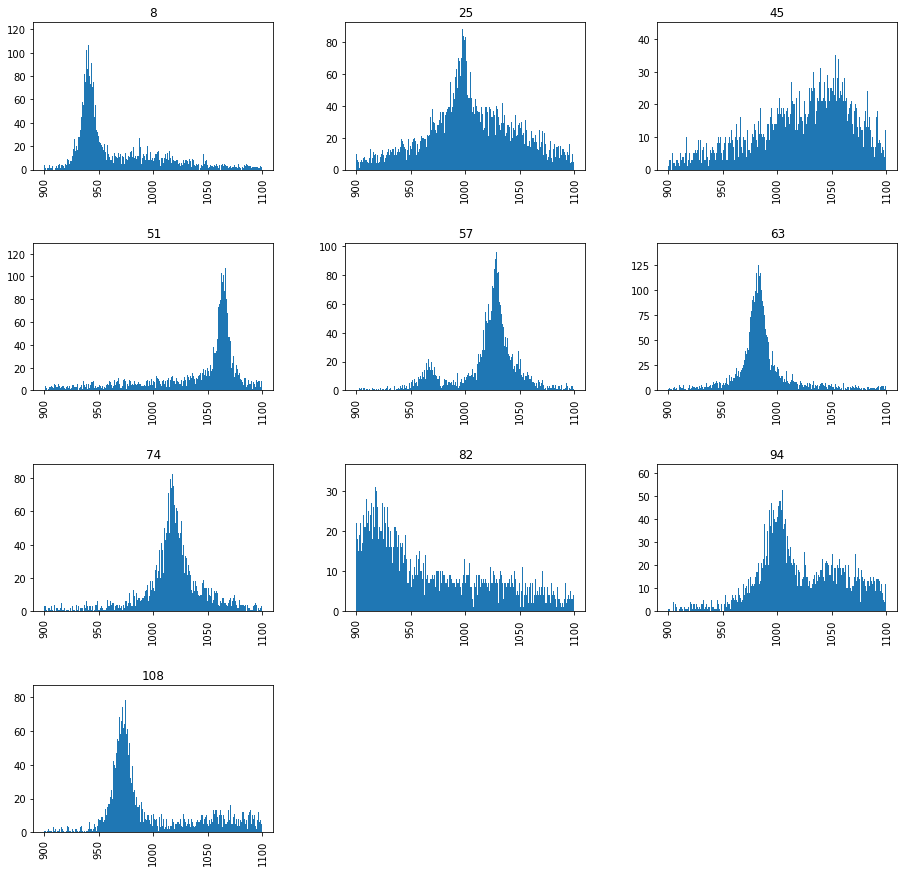

In [132]:
clinic_steps_watch_acc_df['acc_norm'].hist(by=clinic_steps_watch_acc_df['user_id'], figsize=(15,15),
                                           bins=1000, range=(900, 1100))

### Inspect the per patient distribution of the (per-step) accelerometer mean, over time, for step "Sit relaxed":

In [153]:
home_steps_watch_acc_df.sort_values(by='timestamp', ascending=True, inplace=True)
home_steps_watch_mean_norm = home_steps_watch_acc_df[['user_id', 'timestamp', 'assessment_id', 'step_name', 'acc_norm']]\
                             [home_steps_watch_acc_df.step_name=='Sit relaxed']\
                             .groupby(['user_id', 'assessment_id', 'step_name'], as_index=False).agg('mean')

Patient: 8


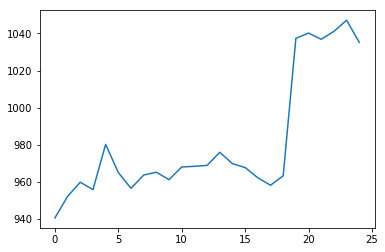

Patient: 25


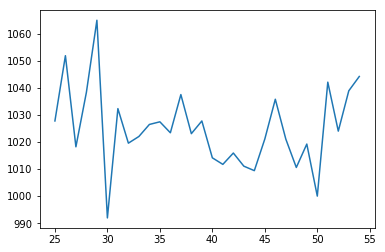

Patient: 45


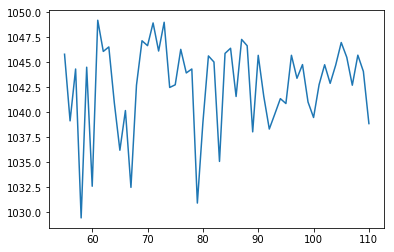

Patient: 51


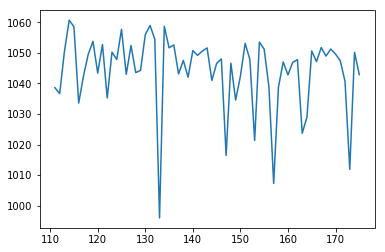

Patient: 57


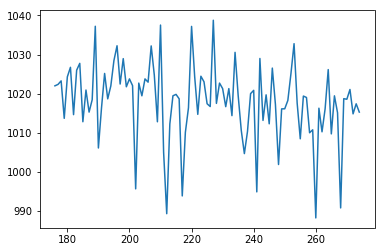

Patient: 63


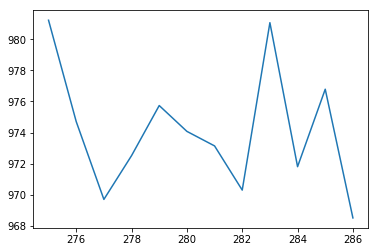

Patient: 74


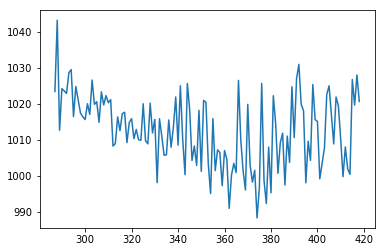

Patient: 82


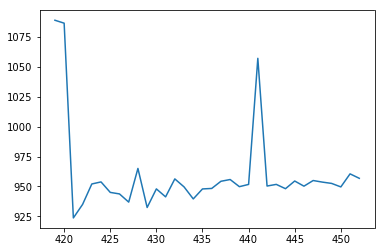

Patient: 94


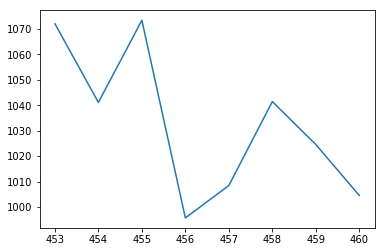

Patient: 108


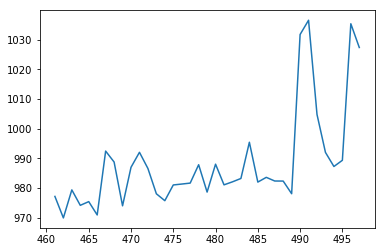

In [154]:
for u in home_steps_watch_mean_norm.user_id.unique():
    print('Patient: %s' % (u))
    plt.plot(home_steps_watch_mean_norm['acc_norm'][home_steps_watch_mean_norm.user_id==u])
    plt.show()
    plt.close()

In [109]:
import os

In [117]:
os.chdir('C:\\Users\\imazeh\\Itzik\\Health_prof\\git_team\\DataScientists')
from Utils.Visualization import box_plot

In [116]:
mean_acc_df = clinic_steps_watch_acc_df[['assessment_id', 'acc_abs_delta', 'patient_report_value']].\
              groupby('assessment_id', as_index=False).agg('mean')

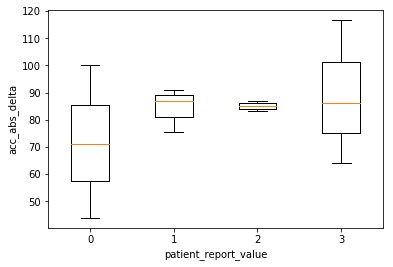

In [139]:
box_plot.create_box_plot(mean_acc_df, 'patient_report_value', 'acc_abs_delta')

In [91]:
def mean_acc_box_plot(df, report_column, variable_column, group_by='assessment_id'):
    mean_acc_df = df[[group_by, variable_column, report_column]]\
                    .groupby(group_by, as_index=False).agg('mean')
    discrete_report_values = c.report_values
    boxes_vals = [np.asarray(mean_acc_df[variable_column][mean_acc_df[report_column] == x]) for x in discrete_report_values]
    plt.boxplot(boxes_vals)
    plt.xticks(range(min_val+1, max_val+2), c.report_values)
#     plt.ylim((920, 1100))
    plt.xlabel('Reported Chorea')
    plt.ylabel("Norm's mean delta from baseline")
    plt.title("%s on %s" % (report_column, df.name))
    plt.show()

### Accelerometer norm mean vs. reported Chorea - clinic patients' reports:

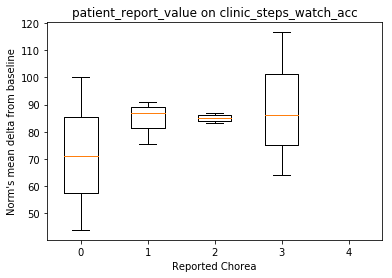

In [92]:
mean_acc_box_plot(clinic_steps_watch_acc_df, 'patient_report_value', 'acc_abs_delta', group_by='assessment_id')

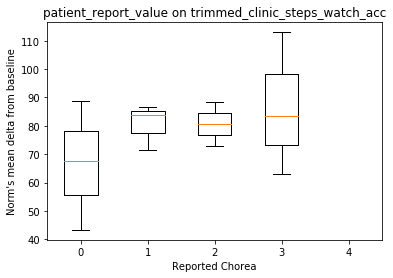

In [93]:
mean_acc_box_plot(trimmed_clinic_steps_watch_acc, 'patient_report_value', 'acc_abs_delta', group_by='assessment_id')

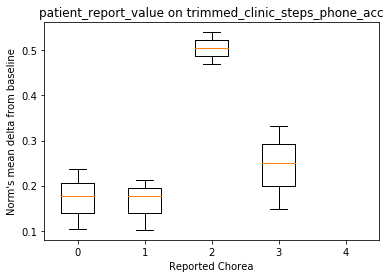

In [94]:
mean_acc_box_plot(trimmed_clinic_steps_phone_acc, 'patient_report_value', 'acc_abs_delta', group_by='assessment_id')

### Accelerometer norm mean vs. reported Chorea - clinic clinicians' reports:

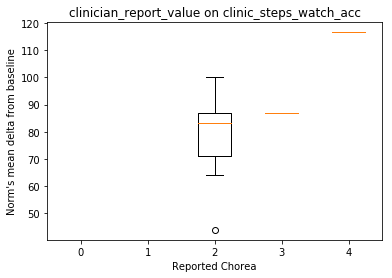

In [95]:
mean_acc_box_plot(clinic_steps_watch_acc_df, 'clinician_report_value', 'acc_abs_delta', group_by='assessment_id')

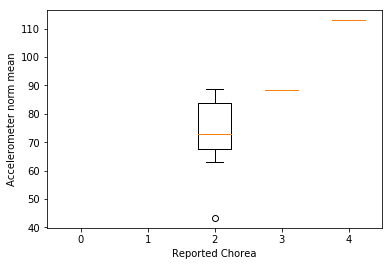

In [67]:
mean_acc_box_plot(trimmed_clinic_steps_watch_acc, 'clinician_report_value', 'acc_abs_delta', group_by='assessment_id')

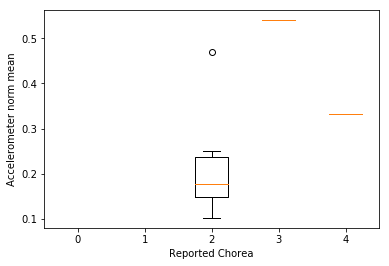

In [68]:
mean_acc_box_plot(trimmed_clinic_steps_phone_acc, 'clinician_report_value', 'acc_abs_delta', group_by='assessment_id')

### Accelerometer norm mean vs. reported Chorea - home patients' reports:

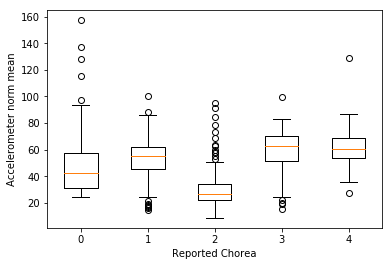

In [75]:
mean_acc_box_plot(home_steps_watch_acc_df, 'patient_report_value', 'acc_abs_delta', group_by='assessment_id')

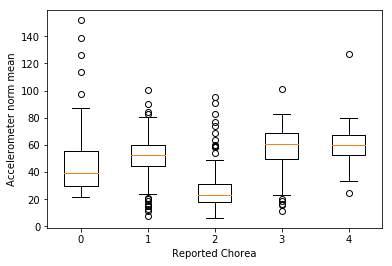

In [76]:
mean_acc_box_plot(trimmed_home_steps_watch_acc, 'patient_report_value', 'acc_abs_delta', group_by='assessment_id')

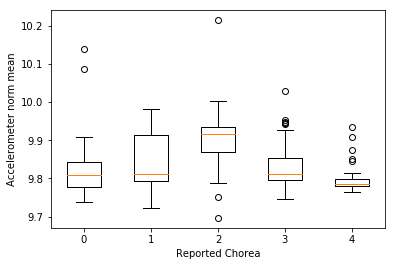

In [71]:
mean_acc_box_plot(home_steps_phone_acc_df, 'patient_report_value', 'acc_norm', group_by='assessment_id')

### Accelerometer norm mean vs. reported Chorea - reminders patients' reports:

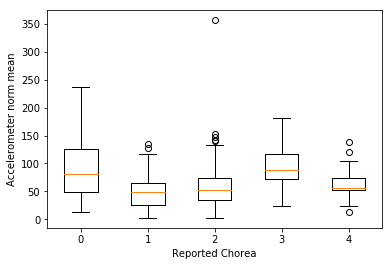

In [14]:
mean_acc_box_plot(home_reminders_watch_acc_df, 'patient_report_value', 'acc_abs_delta', group_by='reminder_id')

## Accelerometer data values per step_name:

In [15]:
clinic_step_agg = clinic_steps_watch_acc_df[['step_name', 'acc_abs_delta']].groupby('step_name', as_index=False).agg('mean')
clinic_step_agg.sort_values(by='acc_abs_delta', inplace=True)
clinic_step_agg

step_name  acc_abs_delta
3   Sit relaxed      52.509823
2  Sit extended      60.307449
4         Stand      71.647589
0         Drink      83.985035
5          TUaG     102.057856
6          Walk     140.883266
1  Rotate hands     202.597351

In [86]:
clinic_step_agg = trimmed_clinic_steps_watch_acc[['step_name', 'acc_abs_delta']].groupby('step_name', as_index=False).agg('mean')
clinic_step_agg.sort_values(by='acc_abs_delta', inplace=True)
clinic_step_agg

step_name  acc_abs_delta
3   Sit relaxed      51.552488
2  Sit extended      59.143095
4         Stand      68.222787
0         Drink      83.327396
5          TUaG     100.538979
6          Walk     145.559612
1  Rotate hands     203.342133

In [16]:
clinic_step_agg = clinic_steps_phone_acc_df[['step_name', 'acc_abs_delta']].groupby('step_name', as_index=False).agg('mean')
clinic_step_agg.sort_values(by='acc_abs_delta', inplace=True)
clinic_step_agg

step_name  acc_abs_delta
2  Sit extended       0.118983
0         Drink       0.144845
1  Rotate hands       0.174296
3   Sit relaxed       0.179817
4         Stand       0.357568
5          TUaG       0.569343
6          Walk       0.924706

In [33]:
home_step_agg = home_steps_watch_acc_df[['step_name', 'acc_abs_delta']].groupby('step_name', as_index=False).agg('mean')
home_step_agg.sort_values(by='acc_abs_delta', inplace=True)
home_step_agg

step_name  acc_abs_delta
0  Sit relaxed      40.661383
1        Stand      54.612115

In [17]:
home_step_agg = home_steps_phone_acc_df[['step_name', 'acc_abs_delta']].groupby('step_name', as_index=False).agg('mean')
home_step_agg.sort_values(by='acc_abs_delta', inplace=True)
home_step_agg

step_name  acc_abs_delta
0  Sit relaxed       0.131270
1        Stand       0.259267

In [41]:
clinic_steps_df.step_name.unique()

array(['Sit relaxed', 'TUaG', 'Sit extended', 'Rotate hands', 'Stand',
       'Drink', 'Walk'], dtype=object)

In [191]:
static_steps_clinic = ['Sit extended', 'Sit relaxed', 'Stand']
static_steps_home = ['Sit relaxed', 'Stand']

## Clinic steps - acc delta from user's baseline, with and without trim - PATIENTS REPORTS:

-----------------------------------------------------------------------------------------
Step: Sit extended in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.158


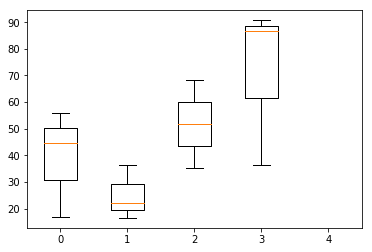

Step: Sit relaxed in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.195


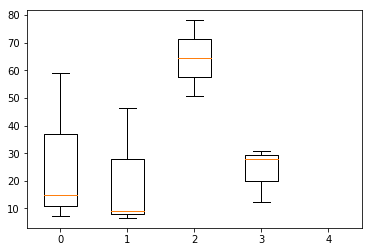

Step: Stand in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.885


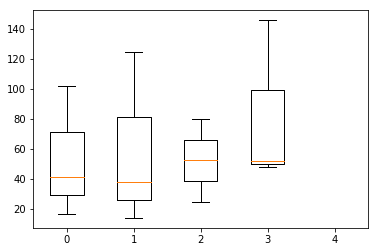

-----------------------------------------------------------------------------------------
Step: Sit extended in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.152


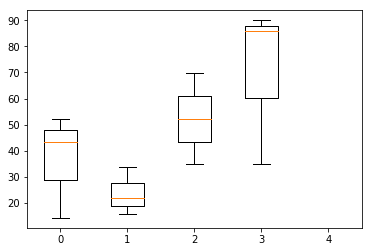

Step: Sit relaxed in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.195


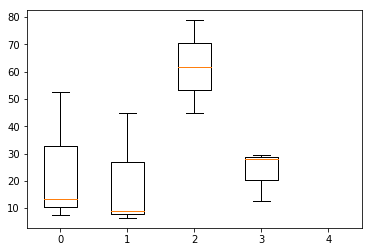

Step: Stand in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.783


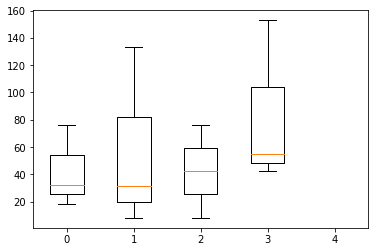

In [209]:
for df in [clinic_steps_watch_acc_w_base, trimmed_clinic_steps_watch_acc_w_base]:
    print('-----------------------------------------------------------------------------------------')
    for step in static_steps_clinic:
        step_df = df[df['step_name']==step]
        agg = step_df[['assessment_id', 'step_name', 'acc_abs_delta_user_bl', 'patient_report_value']]\
              .groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')
        boxes_vals = [np.asarray(agg['acc_abs_delta_user_bl'][agg['patient_report_value'] == x]) for x in discrete_report_values]
        f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2], boxes_vals[3])
        print('Step: %s in %s' % (step, df.name))
        print('p-value of ANOVA: %.3f' % (p))
        plt.boxplot(boxes_vals)
        plt.xticks(range(min_val+1, max_val+2), range(5))
        plt.show()
        plt.close()

## Clinic steps - acc delta from user's baseline, with and without trim - CLINICIANS REPORTS:

----------------------------------------------------------------------
Step: Sit extended in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.155


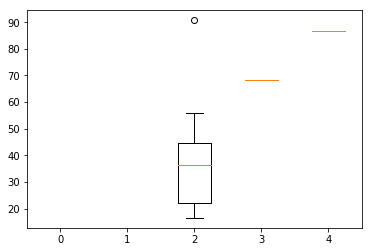

Step: Sit relaxed in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.119


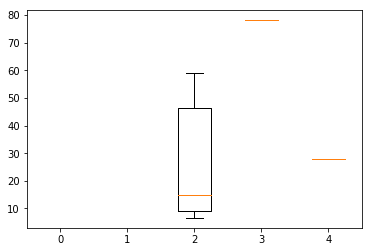

Step: Stand in clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.112


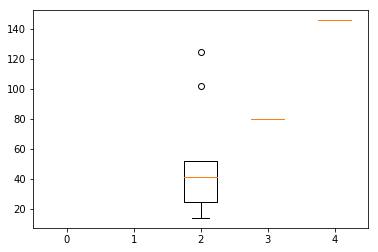

----------------------------------------------------------------------
Step: Sit extended in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.139


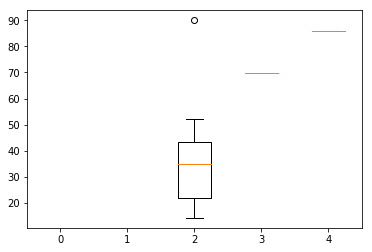

Step: Sit relaxed in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.068


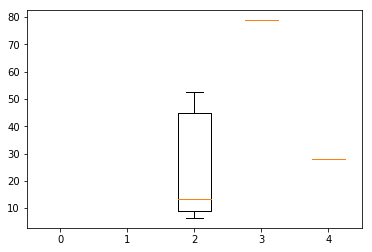

Step: Stand in trimmed_clinic_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.082


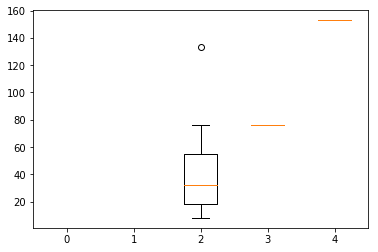

In [202]:
for df in [clinic_steps_watch_acc_w_base, trimmed_clinic_steps_watch_acc_w_base]:
    print('-----------------------------------------------------------------------------------------')
    for step in static_steps_clinic:
        step_df = df[df['step_name']==step]
        agg = step_df[['assessment_id', 'step_name', 'acc_abs_delta_user_bl', 'clinician_report_value']]\
              .groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')
        boxes_vals = [np.asarray(agg['acc_abs_delta_user_bl'][agg['clinician_report_value'] == x]) for x in discrete_report_values]
        f, p = stats.f_oneway(boxes_vals[2], boxes_vals[3], boxes_vals[4])
        print('Step: %s in %s' % (step, df.name))
        print('p-value of ANOVA: %.3f' % (p))
        plt.boxplot(boxes_vals)
        plt.xticks(range(min_val+1, max_val+2), range(5))
        plt.show()
        plt.close()

## Clinic steps - acc delta from general baseline, with and without trim:

-----------------------------------------------------------------------------------------
Step: Sit extended in clinic_steps_watch_acc
p-value of ANOVA: 0.354


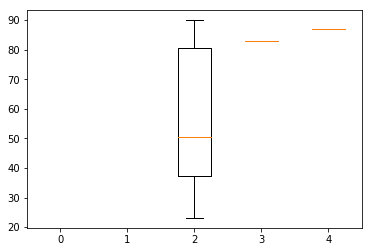

Step: Sit relaxed in clinic_steps_watch_acc
p-value of ANOVA: 0.031


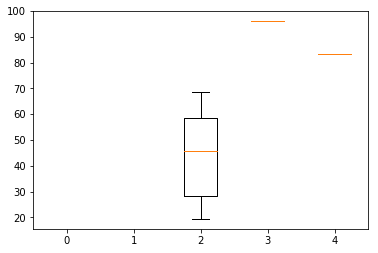

Step: Stand in clinic_steps_watch_acc
p-value of ANOVA: 0.141


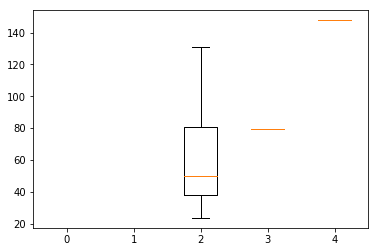

-----------------------------------------------------------------------------------------
Step: Sit extended in trimmed_clinic_steps_watch_acc
p-value of ANOVA: 0.323


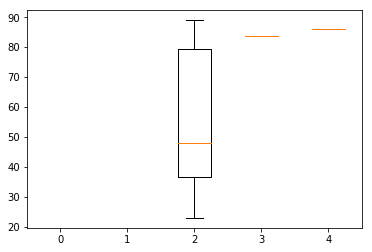

Step: Sit relaxed in trimmed_clinic_steps_watch_acc
p-value of ANOVA: 0.020


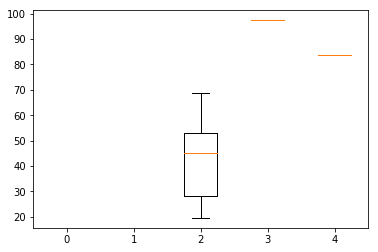

Step: Stand in trimmed_clinic_steps_watch_acc
p-value of ANOVA: 0.112


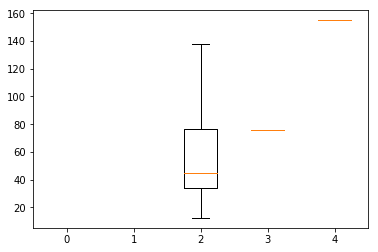

In [204]:
for df in [clinic_steps_watch_acc_df, trimmed_clinic_steps_watch_acc]:
    print('-----------------------------------------------------------------------------------------')
    for step in static_steps_clinic:
        step_df = df[df['step_name']==step]
        agg = step_df[['assessment_id', 'step_name', 'acc_abs_delta', 'clinician_report_value']]\
              .groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')
        boxes_vals = [np.asarray(agg['acc_abs_delta'][agg['clinician_report_value'] == x]) for x in discrete_report_values]
        f, p = stats.f_oneway(boxes_vals[2], boxes_vals[3], boxes_vals[4])
        print('Step: %s in %s' % (step, df.name))
        print('p-value of ANOVA: %.3f' % (p))
        plt.boxplot(boxes_vals)
        plt.xticks(range(min_val+1, max_val+2), range(5))
        plt.show()
        plt.close()

## Home steps - acc delta from user's baseline, with and without trim:

-----------------------------------------------------------------------------------------
Step: Sit relaxed in home_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.000


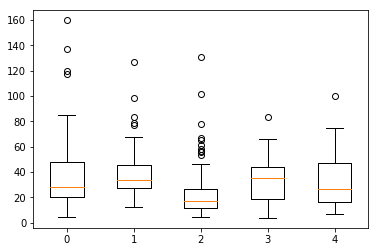

Step: Stand in home_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.000


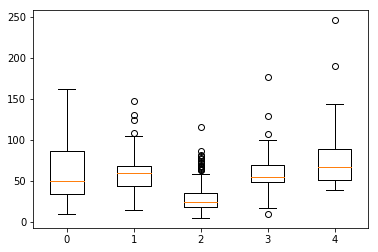

-----------------------------------------------------------------------------------------
Step: Sit relaxed in trimmed_home_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.000


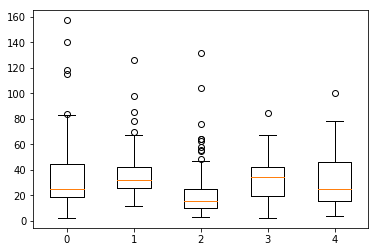

Step: Stand in trimmed_home_steps_watch_acc_with_user_baseline
p-value of ANOVA: 0.000


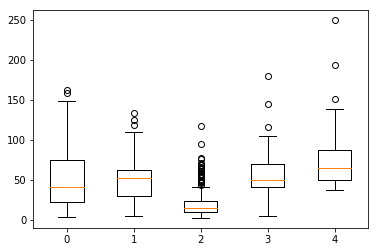

In [205]:
for df in [home_steps_watch_acc_w_base, trimmed_home_steps_watch_acc_w_base]:
    print('-----------------------------------------------------------------------------------------')
    for step in static_steps_home:
        step_df = df[df['step_name']==step]
        agg = step_df[['assessment_id', 'step_name', 'acc_abs_delta_user_bl', 'patient_report_value']]\
              .groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')
        boxes_vals = [np.asarray(agg['acc_abs_delta_user_bl'][agg['patient_report_value'] == x]) for x in discrete_report_values]
        f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2], boxes_vals[3], boxes_vals[4])
        print('Step: %s in %s' % (step, df.name))
        print('p-value of ANOVA: %.3f' % (p))
        plt.boxplot(boxes_vals)
        plt.xticks(range(min_val+1, max_val+2), range(5))
        plt.show()
        plt.close()

## Home steps - acc delta from general baseline, with and without trim:

-----------------------------------------------------------------------------------------
Step: Sit relaxed in home_steps_watch_acc
p-value of ANOVA: 0.000


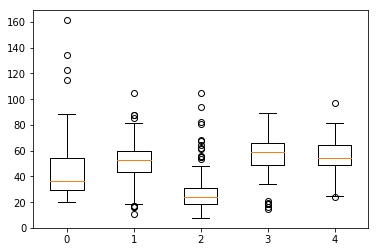

Step: Stand in home_steps_watch_acc
p-value of ANOVA: 0.000


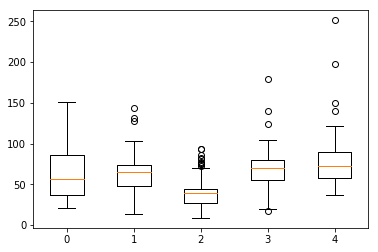

-----------------------------------------------------------------------------------------
Step: Sit relaxed in trimmed_home_steps_watch_acc
p-value of ANOVA: 0.000


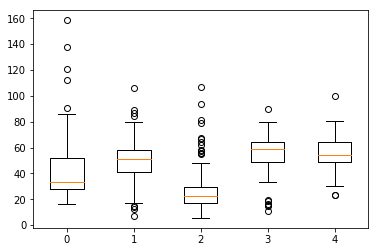

Step: Stand in trimmed_home_steps_watch_acc
p-value of ANOVA: 0.000


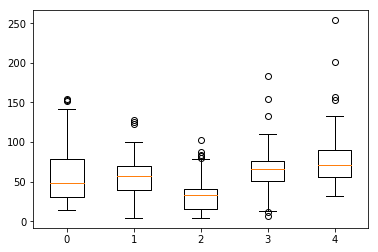

In [206]:
for df in [home_steps_watch_acc_df, trimmed_home_steps_watch_acc]:
    print('-----------------------------------------------------------------------------------------')
    for step in static_steps_home:
        step_df = df[df['step_name']==step]
        agg = step_df[['assessment_id', 'step_name', 'acc_abs_delta', 'patient_report_value']]\
              .groupby(['assessment_id', 'step_name'], as_index=False).agg('mean')
        boxes_vals = [np.asarray(agg['acc_abs_delta'][agg['patient_report_value'] == x]) for x in discrete_report_values]
        f, p = stats.f_oneway(boxes_vals[0], boxes_vals[1], boxes_vals[2], boxes_vals[3], boxes_vals[4])
        print('Step: %s in %s' % (step, df.name))
        print('p-value of ANOVA: %.3f' % (p))
        plt.boxplot(boxes_vals)
        plt.xticks(range(min_val+1, max_val+2), range(5))
        plt.show()
        plt.close()

## Accelerometer data exploration:

In [18]:
home_steps_watch_acc_df[home_steps_watch_acc_df.patient_report_value==0].head(50)

user_id  assessment_id        assessment_start          assessment_end  \
216       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
217       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
218       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
219       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
220       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
221       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
222       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
223       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
224       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
225       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
226       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
227       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
228       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
229       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
230       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
231       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
232       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
233       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
234       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
235       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
236       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
237       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
238       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
239       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
240       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
241       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
242       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
243       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
244       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
245       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
246       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
247       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
248       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
249       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
250       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
251       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
252       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
253       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
254       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
255       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
256       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
257       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
258       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
259       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
260       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
261       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
262       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
263       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
264       63  1494943400069 2017-05-16 14:00:20.836 2017-05-16 14:03:16.601   
265       63  1494943400069 2017-05-16 14:00:20.836 201

In [67]:
home_assess_reported_0 = 1494943400069
home_assess_reported_2 = 1487729046375

In [68]:
watch_level_0_sit = home_steps_watch_acc_df[['x', 'y', 'z']][(home_steps_watch_acc_df.assessment_id==home_assess_reported_0)\
                                                      &(home_steps_watch_acc_df.step_name=='Sit relaxed')]
watch_level_0_stand = home_steps_watch_acc_df[['x', 'y', 'z']][(home_steps_watch_acc_df.assessment_id==home_assess_reported_0)\
                                                        &(home_steps_watch_acc_df.step_name=='Stand')]

In [66]:
watch_level_2_sit = home_steps_watch_acc_df[['x', 'y', 'z']][(home_steps_watch_acc_df.assessment_id==home_assess_reported_2)\
                                                      &(home_steps_watch_acc_df.step_name=='Sit relaxed')]
watch_level_2_stand = home_steps_watch_acc_df[['x', 'y', 'z']][(home_steps_watch_acc_df.assessment_id==home_assess_reported_2)\
                                                        &(home_steps_watch_acc_df.step_name=='Stand')]

NameError: name 'home_assess_reported_2' is not defined

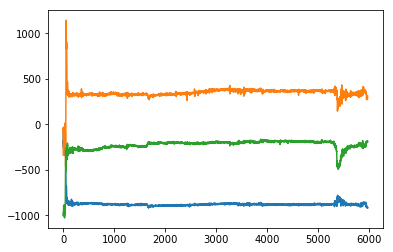

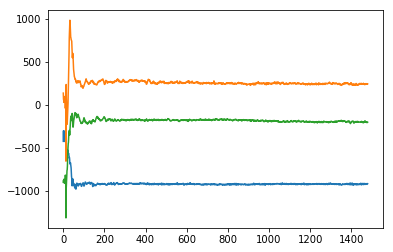

In [27]:
plt.plot(np.asarray(watch_level_0_sit))
plt.show()
plt.plot(np.asarray(watch_level_0_stand))
plt.show()

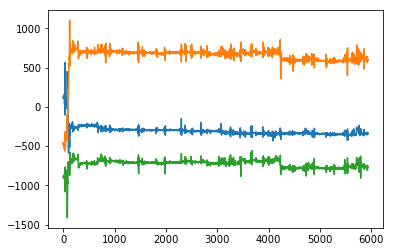

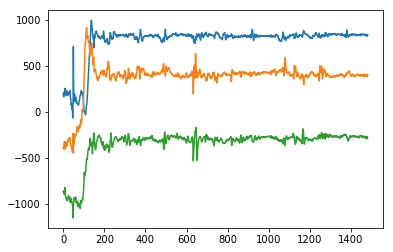

In [28]:
plt.plot(np.asarray(watch_level_2_sit))
plt.show()
plt.plot(np.asarray(watch_level_2_stand))
plt.show()

In [31]:
phone_level_0_sit = home_steps_phone_acc_df[['x', 'y', 'z']][(home_steps_phone_acc_df.assessment_id==home_assess_reported_0)\
                                                      &(home_steps_phone_acc_df.step_name=='Sit relaxed')]
phone_level_0_stand = home_steps_phone_acc_df[['x', 'y', 'z']][(home_steps_phone_acc_df.assessment_id==home_assess_reported_0)\
                                                        &(home_steps_phone_acc_df.step_name=='Stand')]

In [29]:
phone_level_2_sit = home_steps_phone_acc_df[['x', 'y', 'z']][(home_steps_phone_acc_df.assessment_id==home_assess_reported_2)\
                                                      &(home_steps_phone_acc_df.step_name=='Sit relaxed')]
phone_level_2_stand = home_steps_phone_acc_df[['x', 'y', 'z']][(home_steps_phone_acc_df.assessment_id==home_assess_reported_2)\
                                                        &(home_steps_phone_acc_df.step_name=='Stand')]

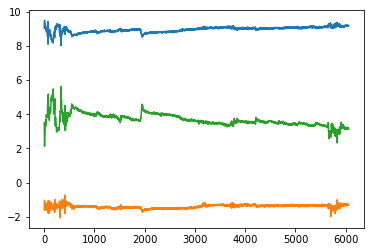

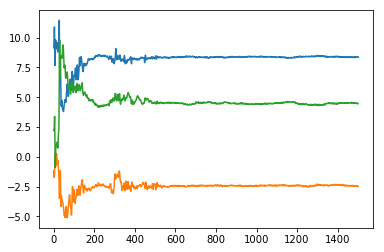

In [32]:
plt.plot(np.asarray(phone_level_0_sit))
plt.show()
plt.plot(np.asarray(phone_level_0_stand))
plt.show()

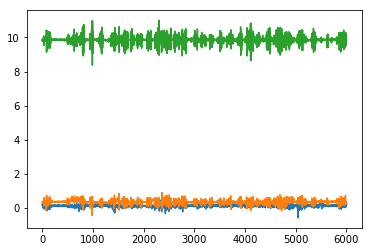

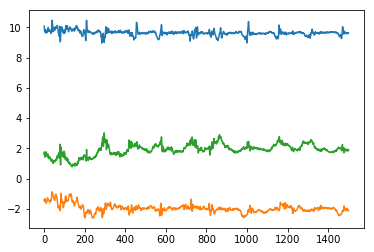

In [33]:
plt.plot(np.asarray(phone_level_2_sit))
plt.show()
plt.plot(np.asarray(phone_level_2_stand))
plt.show()

## Clinic Raw Data Exploration:

In [100]:
for assess in clinic_steps_watch_acc_df.assessment_id.unique():
    assess_df = clinic_steps_watch_acc_df[clinic_steps_watch_acc_df.assessment_id==assess].copy()
    print('\n\nuser: %s, assessment: %s' % (assess_df['user_id'].unique()[0], assess_df['assessment_id'].unique()[0]))
    steps_list = []
    for index, row in assess_df.sort_values(by='timestamp').iterrows():
        step = row['step_name']
        if steps_list == []:
            steps_list.append((step, index))
        else:
            if step != steps_list[-1][0]:
                steps_list.append((step, index))
    print('# of steps:', len(steps_list))
    print('steps:', steps_list)
        

#     user_id = row['user_id']
#     assessment_id = row['assessment_id']
#     user_assess_df = clinic_steps_watch_acc_df[(clinic_steps_watch_acc_df.user_id==user_id)
#                                               &(clinic_steps_watch_acc_df.assessment_id==assessment_id)]
# #     step_name = row['step_name']



user: 82, assessment: 1489765988342
# of steps: 7
steps: [('TUaG', 388), ('Sit relaxed', 3115), ('Sit extended', 14651), ('Stand', 13932), ('Walk', 20798), ('Drink', 24681), ('Rotate hands', 26870)]


user: 63, assessment: 1493920652116
# of steps: 6
steps: [('Sit relaxed', 4261), ('Sit extended', 22476), ('Stand', 27058), ('Walk', 21145), ('Drink', 160840), ('Rotate hands', 12398)]


user: 45, assessment: 1490637319938
# of steps: 7
steps: [('TUaG', 31321), ('Sit relaxed', 56332), ('Sit extended', 34896), ('Stand', 42366), ('Walk', 46080), ('Drink', 50720), ('Rotate hands', 52871)]


user: 8, assessment: 1490640580656
# of steps: 7
steps: [('TUaG', 32657), ('Sit relaxed', 31659), ('Sit extended', 43736), ('Stand', 46508), ('Walk', 49507), ('Drink', 52113), ('Rotate hands', 54480)]


user: 74, assessment: 1485546321147
# of steps: 7
steps: [('TUaG', 66175), ('Sit relaxed', 66426), ('Sit extended', 72486), ('Stand', 59677), ('Walk', 63683), ('Drink', 65227), ('Rotate hands', 63743)]



In [74]:
first_indx_df = trimmed_clinic_steps_watch_acc_w_base[['user_id', 'assessment_id', 'step_name']].drop_duplicates(keep='first')\
                .sort_values(by=['user_id', 'assessment_id'])
print(first_indx_df.head(30))
last_indx_df = trimmed_clinic_steps_watch_acc_w_base[['user_id', 'assessment_id', 'step_name']].drop_duplicates(keep='last')\
               .sort_values(by=['user_id', 'assessment_id'])
print(last_indx_df.head(30))
# indxs_dict = dict()
# for index, row in indx_df.iterrows():
#     user = row['user_id']
#     if user not in indxs_dict:
#         indxs_dict[user] = []
#     indxs_dict.append()
#     print('index: %.0f, step: %s' % (index, row['step_name']))

        user_id  assessment_id     step_name
40406         8  1490640580656   Sit relaxed
46040         8  1490640580656          TUaG
46339         8  1490640580656  Sit extended
48931         8  1490640580656         Stand
50027         8  1490640580656          Walk
50375         8  1490640580656         Drink
50960         8  1490640580656  Rotate hands
82190        25  1487605701264   Sit relaxed
90227        25  1487605701264  Sit extended
93848        25  1487605701264         Stand
95602        25  1487605701264          Walk
97700        25  1487605701264         Drink
100290       25  1487605701264  Rotate hands
136139       25  1487605701264          TUaG
76677        25  1493912424448   Sit relaxed
87670        25  1493912424448  Sit extended
92769        25  1493912424448         Stand
94918        25  1493912424448          Walk
96819        25  1493912424448         Drink
99211        25  1493912424448  Rotate hands
26050        45  1490637319938          TUaG
28358     

In [90]:
trimmed_clinic_steps_watch_acc_w_base.head()

user_id  assessment_id        assessment_start          assessment_end  \
0       82  1489765988342 2017-03-17 15:43:54.743 2017-03-17 15:53:08.333   
1       82  1489765988342 2017-03-17 15:43:54.743 2017-03-17 15:53:08.333   
2       82  1489765988342 2017-03-17 15:43:54.743 2017-03-17 15:53:08.333   
3       82  1489765988342 2017-03-17 15:43:54.743 2017-03-17 15:53:08.333   
4       82  1489765988342 2017-03-17 15:43:54.743 2017-03-17 15:53:08.333   

                timestamp    step_name      x     y      z  \
0 2017-03-17 15:46:03.785  Sit relaxed -891.0  73.0 -222.0   
1 2017-03-17 15:46:03.805  Sit relaxed -889.0  83.0 -207.0   
2 2017-03-17 15:46:03.825  Sit relaxed -891.0  87.0 -193.0   
3 2017-03-17 15:46:03.849  Sit relaxed -890.0  86.0 -182.0   
4 2017-03-17 15:46:03.869  Sit relaxed -890.0  87.0 -182.0   

   patient_report_value  clinician_report_value    acc_norm  acc_abs_delta  \
0                   3.0                     4.0  921.137340      78.862660   
1                   3.0                     4.0  916.547326      83.452674   
2                   3.0                     4.0  915.805110      84.194890   
3                   3.0                     4.0  912.480137      87.519863   
4                   3.0                     4.0  912.574928      87.425072   

   acc_norm_mean  acc_abs_delta_user_bl  
0     920.520361               0.616980  
1     920.520361               3.973035  
2     920.520361               4.715250  
3     920.520361               8.040224  
4     920.520361               7.945432

In [103]:
assess_bla = trimmed_clinic_steps_watch_acc_w_base[trimmed_clinic_steps_watch_acc_w_base['assessment_id']==1487605701264].copy()

In [105]:
assess_bla.head()

user_id  assessment_id        assessment_start          assessment_end  \
82190       25  1487605701264 2017-02-20 15:39:42.020 2017-02-20 15:48:21.258   
82191       25  1487605701264 2017-02-20 15:39:42.020 2017-02-20 15:48:21.258   
82192       25  1487605701264 2017-02-20 15:39:42.020 2017-02-20 15:48:21.258   
82193       25  1487605701264 2017-02-20 15:39:42.020 2017-02-20 15:48:21.258   
82194       25  1487605701264 2017-02-20 15:39:42.020 2017-02-20 15:48:21.258   

                    timestamp    step_name      x       y      z  \
82190 2017-02-20 15:41:47.918  Sit relaxed  198.0   846.0  501.0   
82191 2017-02-20 15:41:47.938  Sit relaxed  216.0  1026.0  253.0   
82192 2017-02-20 15:41:47.958  Sit relaxed  567.0  1203.0  -89.0   
82193 2017-02-20 15:41:47.978  Sit relaxed  578.0  1096.0 -102.0   
82194 2017-02-20 15:41:47.998  Sit relaxed  435.0  1099.0 -242.0   

       patient_report_value  clinician_report_value     acc_norm  \
82190                   1.0                     2.0  1002.956131   
82191                   1.0                     2.0  1078.582867   
82192                   1.0                     2.0  1332.898721   
82193                   1.0                     2.0  1243.263448   
82194                   1.0                     2.0  1206.478346   

       acc_abs_delta  acc_norm_mean  acc_abs_delta_user_bl  
82190       2.956131     998.796372               4.159759  
82191      78.582867     998.796372              79.786495  
82192     332.898721     998.796372             334.102349  
82193     243.263448     998.796372             244.467076  
82194     206.478346     998.796372             207.681974

In [104]:
df_bla = assess_bla.sort_values(by='timestamp')
# df_bla_first = assess_bla[['assessment_id', 'step_name']][trimmed_bla['assessment_id']==1487605701264]\
#                .drop_duplicates(keep='first')
# print(df_bla_first)
# df_bla_last = trimmed_bla[['assessment_id', 'step_name']][trimmed_bla['assessment_id']==1487605701264]\
#               .drop_duplicates(keep='last')
# print(df_bla_last)

In [ ]:
for index, row in assess_bla.sort_values(by='timestamp').iterrows():
    

In [91]:
trimmed_bla = trimmed_clinic_steps_watch_acc_w_base.sort_values(by='timestamp')

In [101]:
df_bla_first = trimmed_bla[['assessment_id', 'step_name']][trimmed_bla['assessment_id']==1487605701264]\
               .drop_duplicates(keep='first')
print(df_bla_first)
df_bla_last = trimmed_bla[['assessment_id', 'step_name']][trimmed_bla['assessment_id']==1487605701264]\
              .drop_duplicates(keep='last')
print(df_bla_last)

        assessment_id     step_name
136139  1487605701264          TUaG
82508   1487605701264   Sit relaxed
90227   1487605701264  Sit extended
93848   1487605701264         Stand
95602   1487605701264          Walk
97700   1487605701264         Drink
100290  1487605701264  Rotate hands
        assessment_id     step_name
136522  1487605701264          TUaG
86434   1487605701264   Sit relaxed
90555   1487605701264  Sit extended
94917   1487605701264         Stand
96818   1487605701264          Walk
99210   1487605701264         Drink
101359  1487605701264  Rotate hands


In [102]:
for indx, row in df_bla_first.iterrows():
    step = row['step_name']
    print('\nstep:', step)
    print('first index:', indx)
    last_index = df_bla_last[df_bla_last['step_name']==step].index
    print('last index:', last_index[0])


step: TUaG
first index: 136139
last index: 136522

step: Sit relaxed
first index: 82508
last index: 86434

step: Sit extended
first index: 90227
last index: 90555

step: Stand
first index: 93848
last index: 94917

step: Walk
first index: 95602
last index: 96818

step: Drink
first index: 97700
last index: 99210

step: Rotate hands
first index: 100290
last index: 101359


In [116]:
def plot_assessment_with_steps(df, sensor):
    if sensor=='watch':
        ylim = 2000
        y_label_delta = 40
    elif sensor=='phone':
        ylim = 20
        y_label_delta = 0.5
    sorted_df = df.sort_values(by='timestamp', ascending=True)
    assessments = sorted_df['assessment_id'].unique()
    for assess in assessments:
        assess_df = sorted_df[sorted_df['assessment_id']==assess].copy()
        assess_df.reset_index(inplace=True)
        
        patient = assess_df['user_id'].unique()[0]
        assessment = assess_df['assessment_id'].unique()[0]
        patient_report = assess_df['patient_report_value'].unique()[0]
        clinician_report = assess_df['clinician_report_value'].unique()[0]
        print('\n\nuser: %s, assessment: %s' % (patient, assessment))
        print('patient report: %.0f, clinician report: %.0f' % (patient_report, clinician_report))
        
        trimmed_assess_df = trim_per_step(assess_df, trim_dict=trim_dict)
        trimmed_assess_df.reset_index(inplace=True)
        
        for assessment_df in [assess_df, trimmed_assess_df]:
            steps_indxs = dict()
            
            first_indx_df = assessment_df[['assessment_id', 'step_name']].drop_duplicates(keep='first')
            last_indx_df = assessment_df[['assessment_id', 'step_name']].drop_duplicates(keep='last')
            for index, row in first_indx_df.iterrows():
                step = row['step_name']
                first_index = index
                last_index = last_indx_df[last_indx_df['step_name']==step].index
                if step not in steps_indxs:
                    steps_indxs[step] = (first_index, last_index[0])
        
            norm_values = assessment_df[['assessment_id', 'acc_abs_delta_user_bl']]
            norm = np.mean(norm_values['acc_abs_delta_user_bl'])
            print("Norm's mean delta from baseline: %.2f" % (norm))
        
            signal = assessment_df[['x', 'y', 'z']]
            signal = np.asarray(signal)
            plt.figure(figsize=(20,5))
            plt.plot(signal)
            plt.ylim(-ylim, ylim)
            plt.xticks(range(0, signal.shape[0], 500), range(0, int(signal.shape[0]/50), 10))
            for step in steps_indxs:
                step_start = int(steps_indxs[step][0])
                step_end = int(steps_indxs[step][1])
    #             step_len = int(step_end-step_start)
    #             text_len = len(step)
    #             label = "|"+"-"*int((step_len-text_len)/2)+step+"-"*int((step_len-text_len)/2)+"|"
                plt.text(step_start, ylim+y_label_delta, '|', fontsize=25)
                plt.text(step_start+100, ylim+y_label_delta, step, fontsize=9)
            plt.show()
            plt.close()

In [100]:
def plot_assessment_with_steps(df, sensor):
    if sensor=='watch':
        ylim = 2000
        y_label_delta = 40
    elif sensor=='phone':
        ylim = 20
        y_label_delta = 0.5
    sorted_df = df.sort_values(by='timestamp', ascending=True)
    assessments = sorted_df['assessment_id'].unique()
    for assess in assessments:
        steps_indxs = dict()
        assess_df = sorted_df[sorted_df['assessment_id']==assess].copy()
        assess_df.reset_index(inplace=True)
        
        patient = assess_df['user_id'].unique()[0]
        assessment = assess_df['assessment_id'].unique()[0]
        patient_report = assess_df['patient_report_value'].unique()[0]
        clinician_report = assess_df['clinician_report_value'].unique()[0]
        print('\n\nuser: %s, assessment: %s' % (patient, assessment))
        print('patient report: %.0f, clinician report: %.0f' % (patient_report, clinician_report))
        
        trimmed_assess_df = trim_per_step(assess_df, trim_dict=trim_dict)
        
        first_indx_df = assess_df[['assessment_id', 'step_name']].drop_duplicates(keep='first')
        last_indx_df = assess_df[['assessment_id', 'step_name']].drop_duplicates(keep='last')
        for index, row in first_indx_df.iterrows():
            step = row['step_name']
            first_index = index
            last_index = last_indx_df[last_indx_df['step_name']==step].index
            if step not in steps_indxs:
                steps_indxs[step] = (first_index, last_index[0])
        
        norm_values = assess_df[['assessment_id', 'acc_abs_delta_user_bl']]
        norm = np.mean(norm_values['acc_abs_delta_user_bl'])
        print("Norm's mean delta from baseline: %.2f" % (norm))
        signal = assess_df[['x', 'y', 'z']]
        signal = np.asarray(signal)
        plt.figure(figsize=(20,5))
        plt.plot(signal)
        plt.ylim(-ylim, ylim)
        plt.xticks(range(0, signal.shape[0], 500), range(0, int(signal.shape[0]/50), 10))
        for step in steps_indxs:
            step_start = int(steps_indxs[step][0])
            step_end = int(steps_indxs[step][1])
#             step_len = int(step_end-step_start)
#             text_len = len(step)
#             label = "|"+"-"*int((step_len-text_len)/2)+step+"-"*int((step_len-text_len)/2)+"|"
            plt.text(step_start, ylim+y_label_delta, '|', fontsize=25)
            plt.text(step_start+100, ylim+y_label_delta, step, fontsize=9)
            
#             plt.plot((step_end, step_end), (ylim+y_label_delta, ylim+(y_label_delta*20)), 'b')
        plt.show()
        plt.close()



user: 57, assessment: 1481923232988
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 77.06


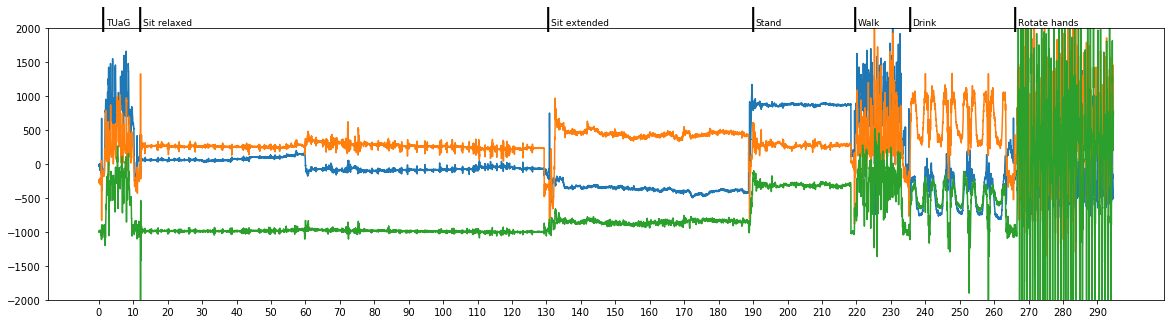

Norm's mean delta from baseline: 75.05


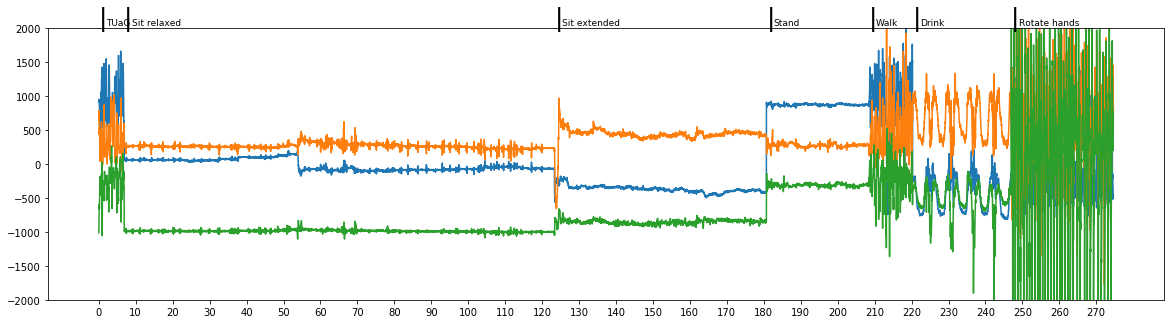



user: 74, assessment: 1485546321147
patient report: 2, clinician report: 2
Norm's mean delta from baseline: 81.24


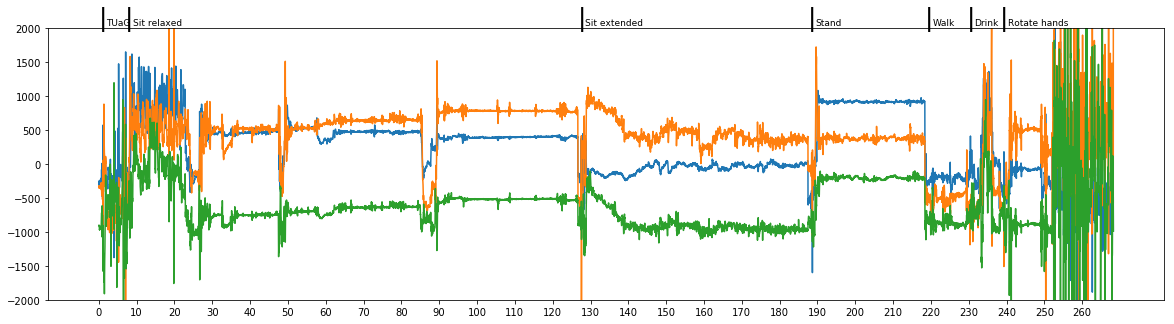

Norm's mean delta from baseline: 75.26


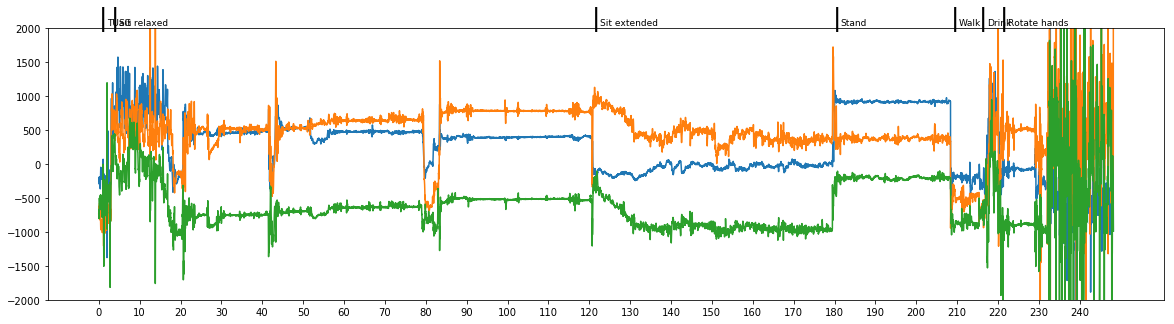



user: 25, assessment: 1487605701264
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 84.47


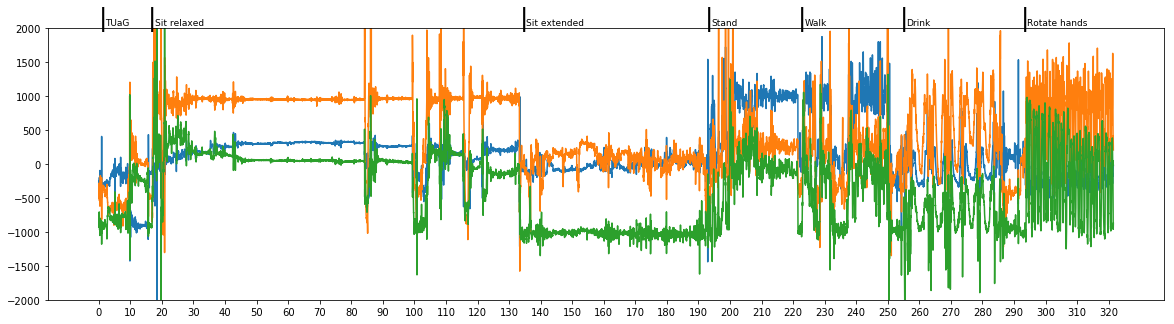

Norm's mean delta from baseline: 83.78


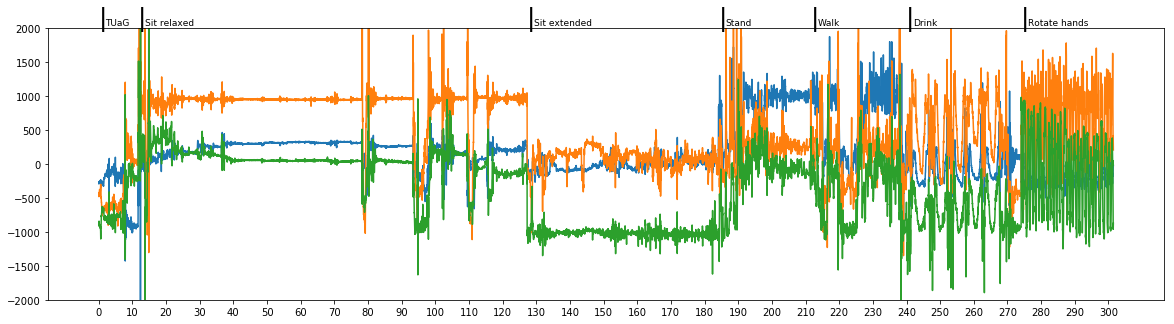



user: 108, assessment: 1488396181636
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 50.81


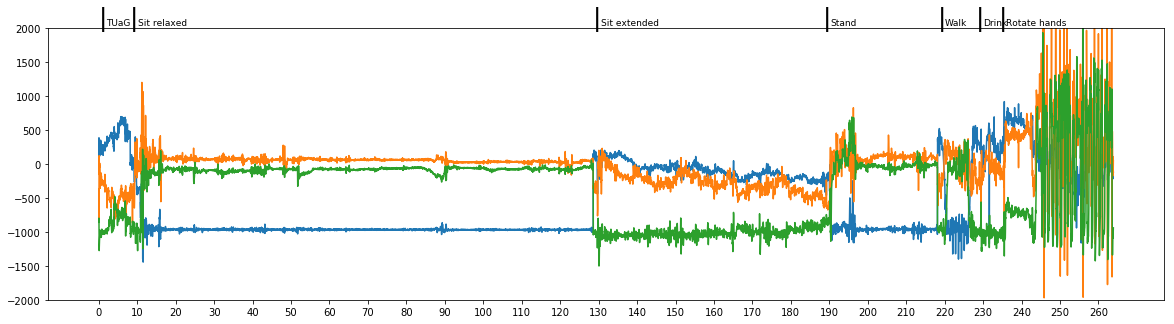

Norm's mean delta from baseline: 49.24


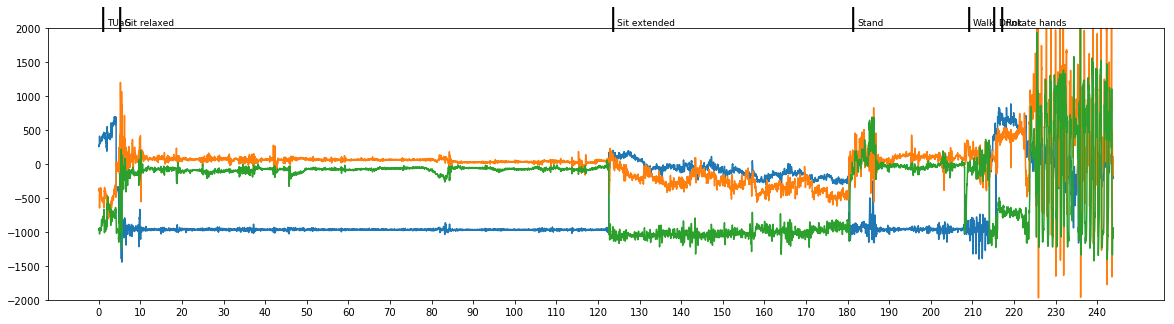



user: 82, assessment: 1489765988342
patient report: 3, clinician report: 4
Norm's mean delta from baseline: 93.58


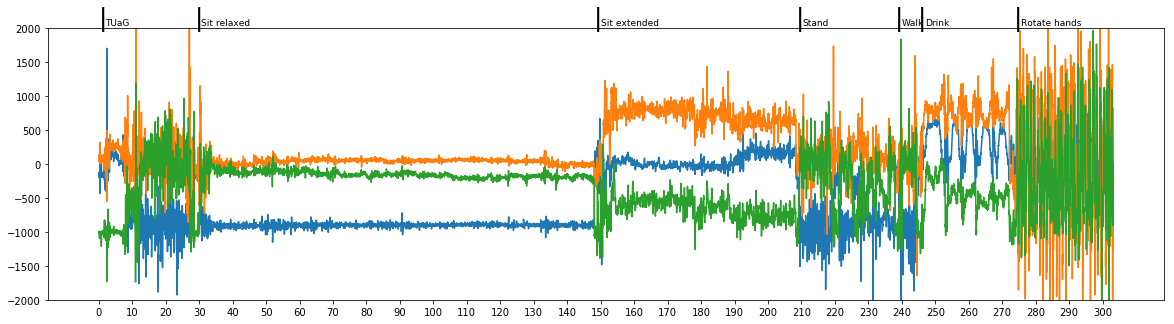

Norm's mean delta from baseline: 89.49


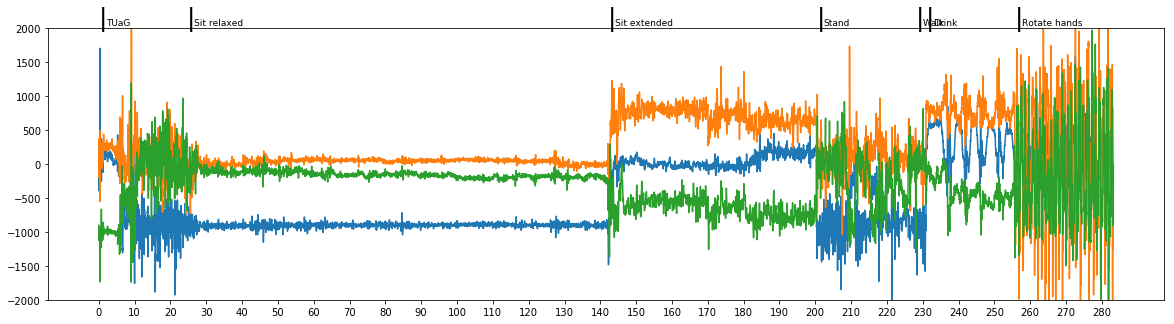



user: 51, assessment: 1490284781631
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 58.53


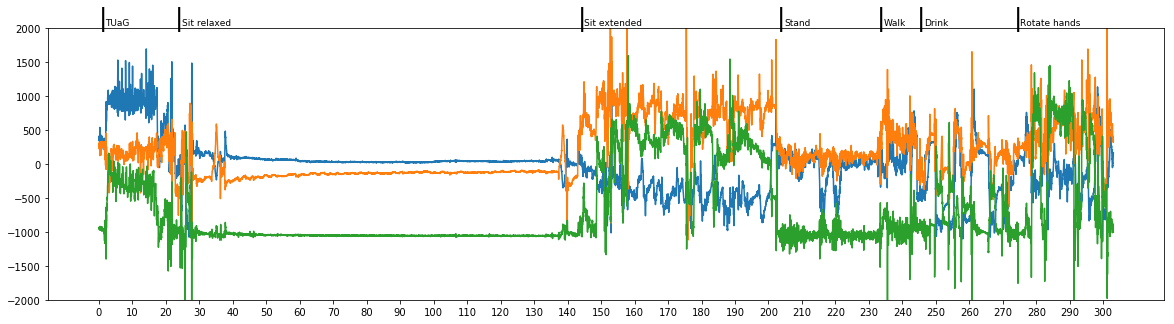

Norm's mean delta from baseline: 56.95


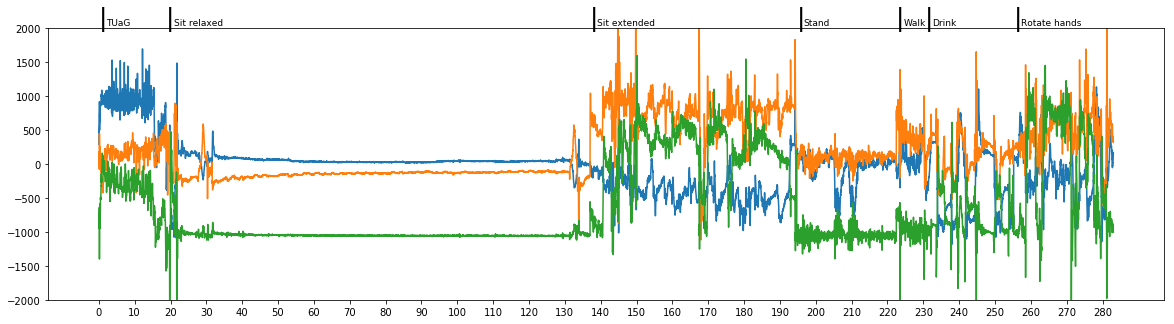



user: 45, assessment: 1490637319938
patient report: 2, clinician report: 3
Norm's mean delta from baseline: 75.91


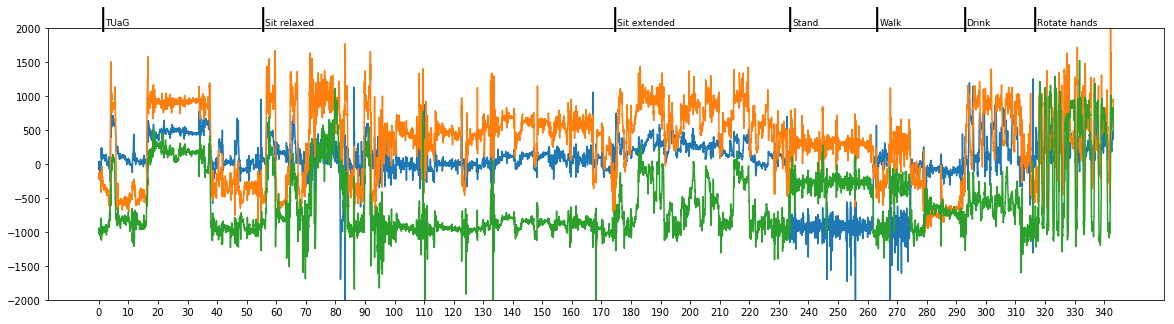

Norm's mean delta from baseline: 76.18


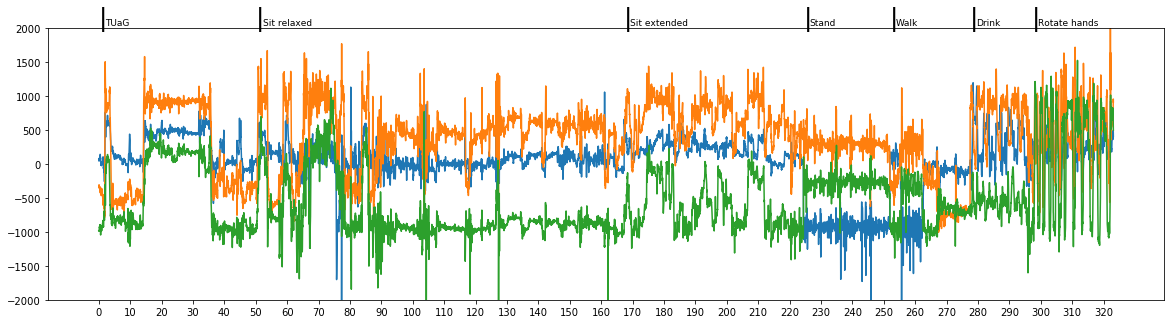



user: 8, assessment: 1490640580656
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 49.12


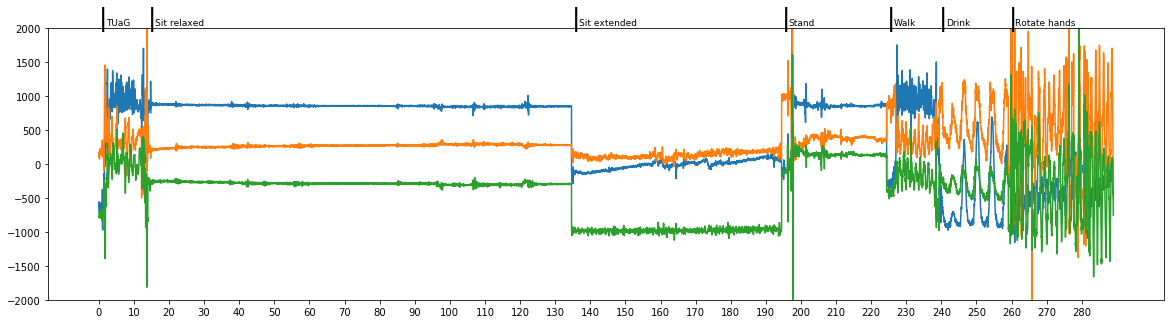

Norm's mean delta from baseline: 45.70


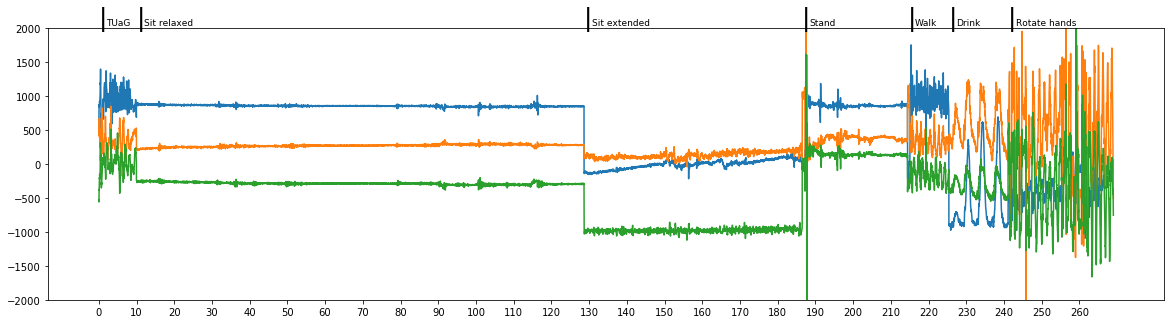



user: 94, assessment: 1493741957038
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 52.68


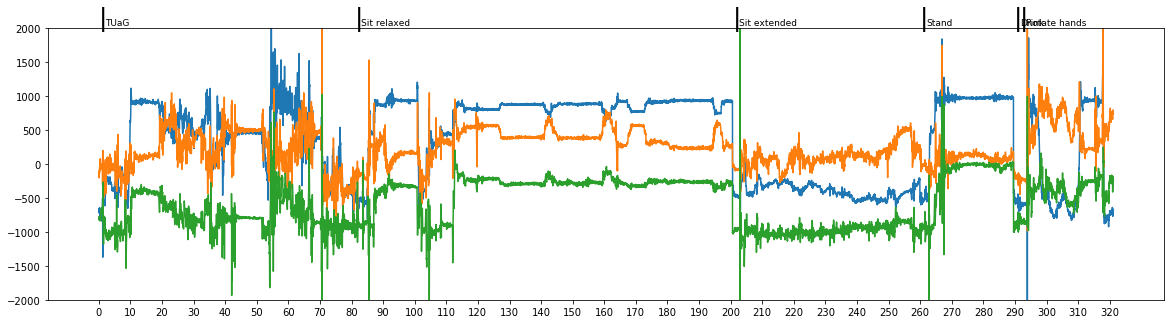

Norm's mean delta from baseline: 53.23


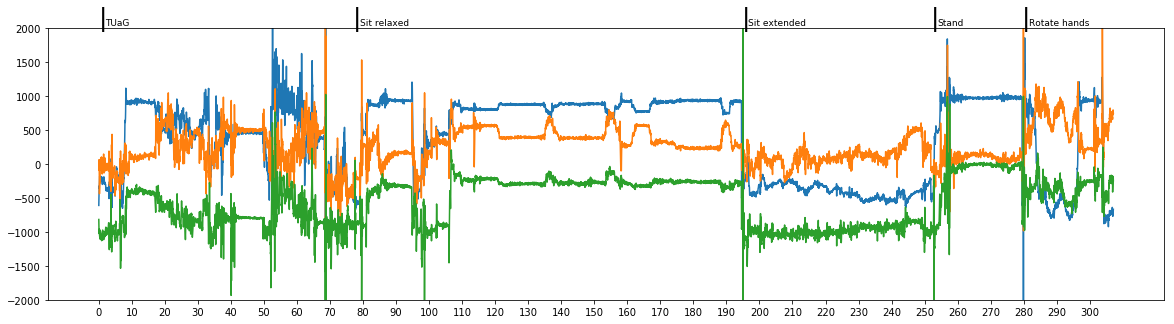



user: 25, assessment: 1493912424448
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 99.02


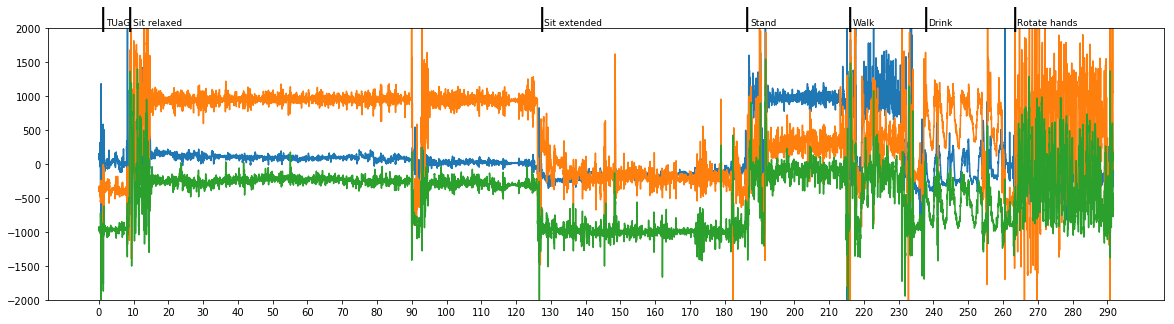

Norm's mean delta from baseline: 94.86


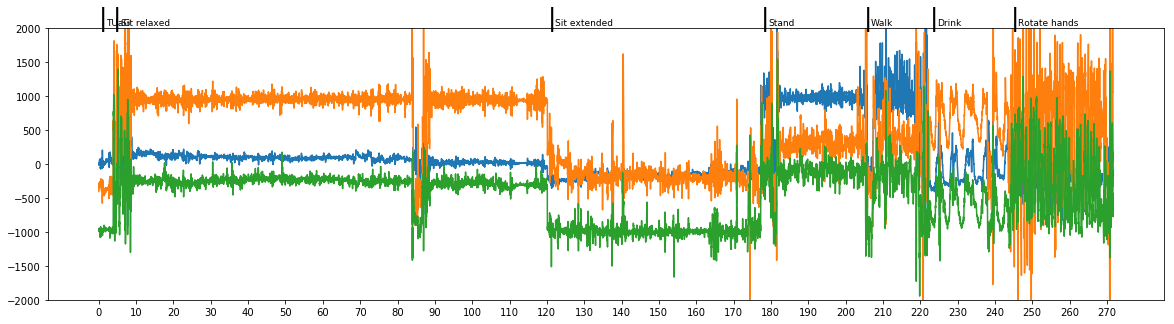



user: 63, assessment: 1493920652116
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 36.10


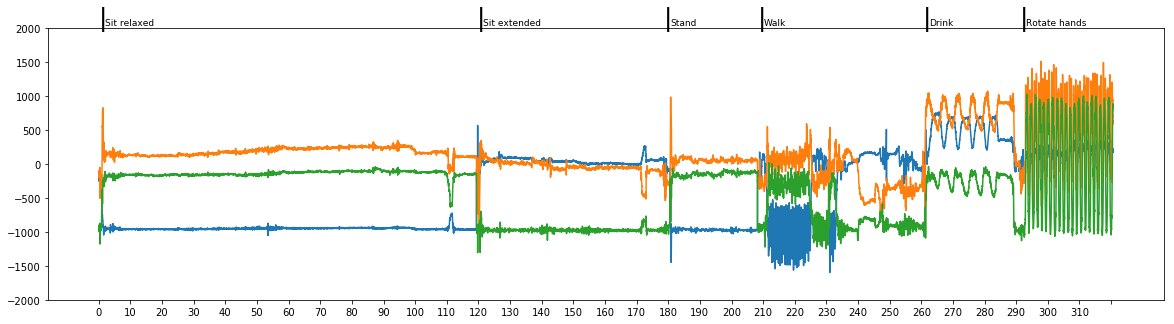

Norm's mean delta from baseline: 35.32


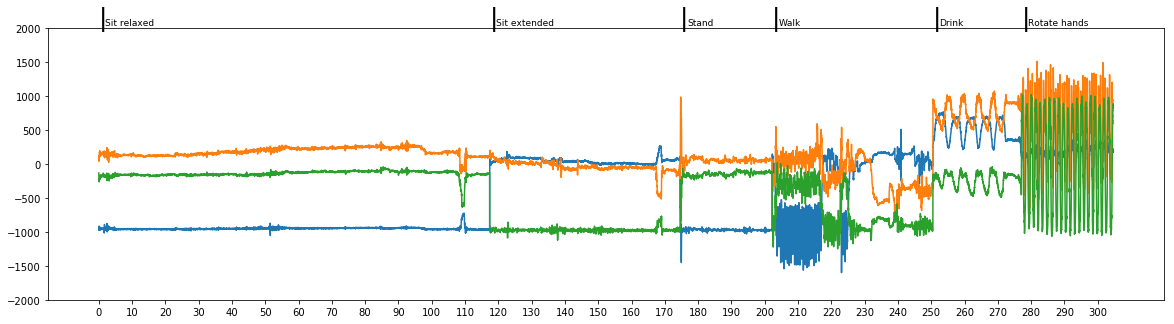

In [118]:
plot_assessment_with_steps(clinic_steps_watch_acc_w_base, 'watch')



user: 57, assessment: 1481923232988
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 0.09


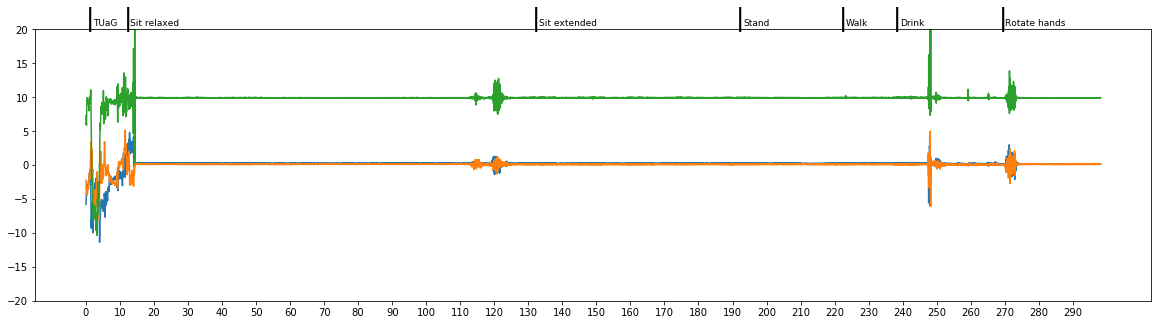

Norm's mean delta from baseline: 0.07


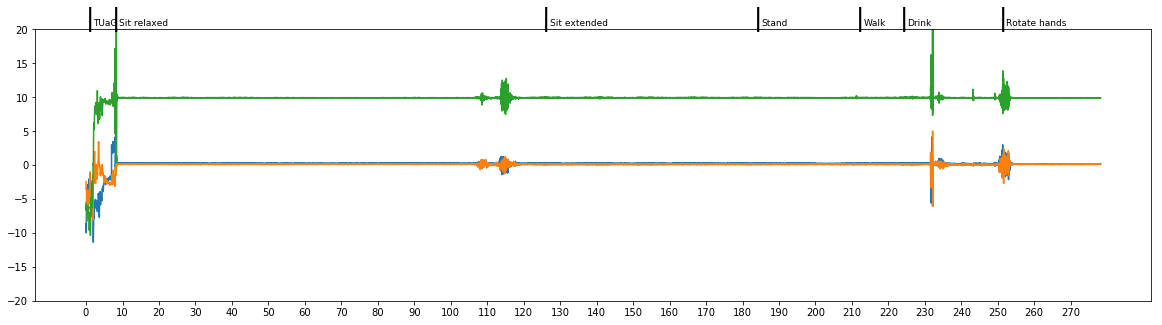



user: 74, assessment: 1485546321147
patient report: 2, clinician report: 2
Norm's mean delta from baseline: 0.44


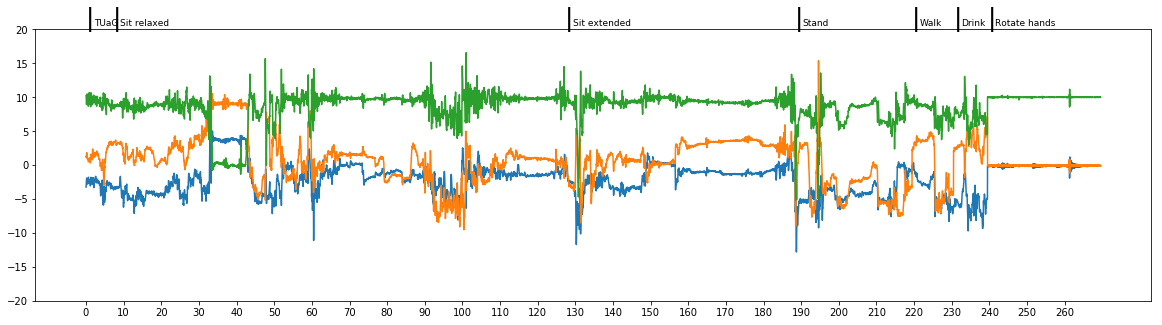

Norm's mean delta from baseline: 0.44


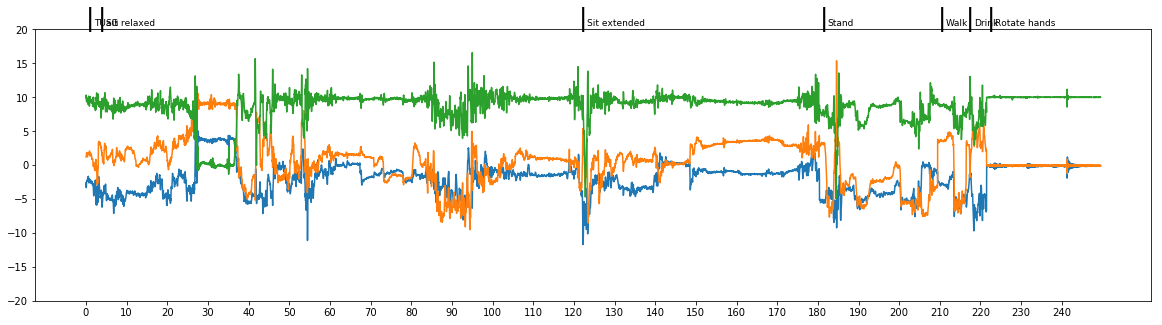



user: 25, assessment: 1487605701264
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 0.21


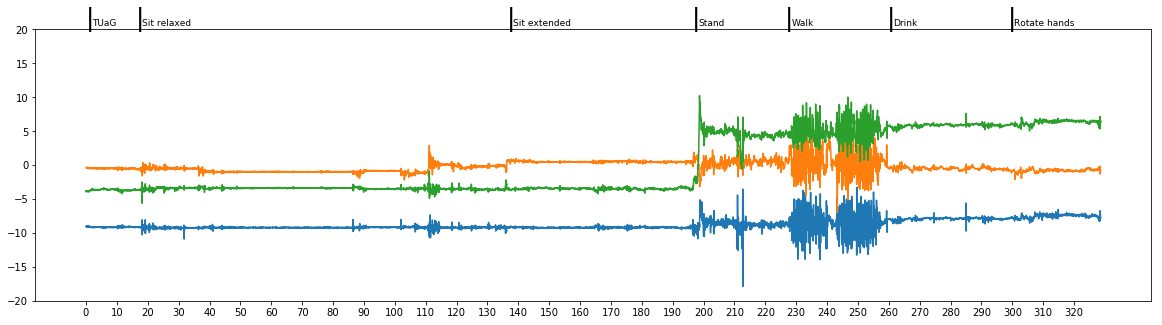

Norm's mean delta from baseline: 0.22


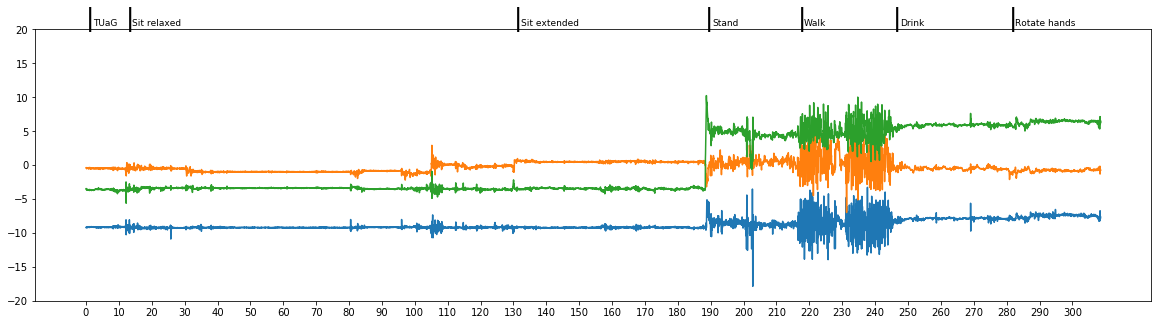



user: 108, assessment: 1488396181636
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 0.12


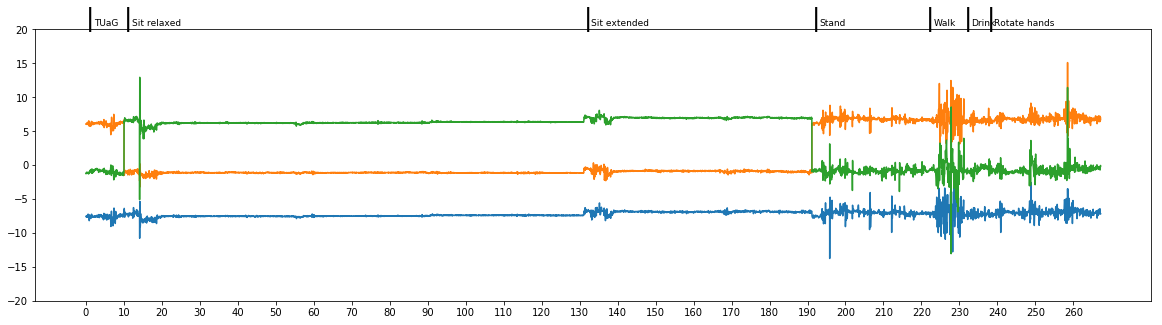

Norm's mean delta from baseline: 0.11


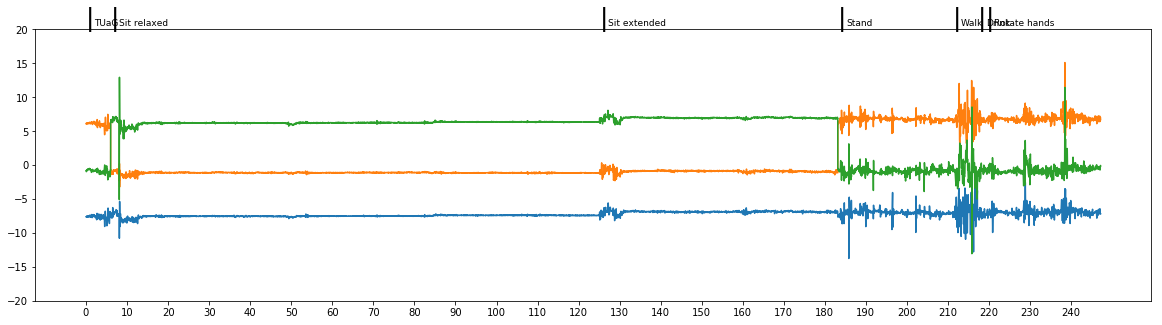



user: 82, assessment: 1489765988342
patient report: 3, clinician report: 4
Norm's mean delta from baseline: 0.33


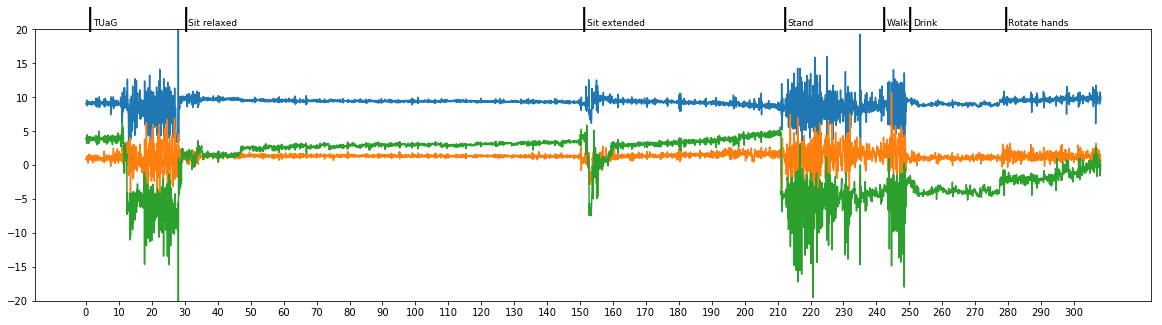

Norm's mean delta from baseline: 0.31


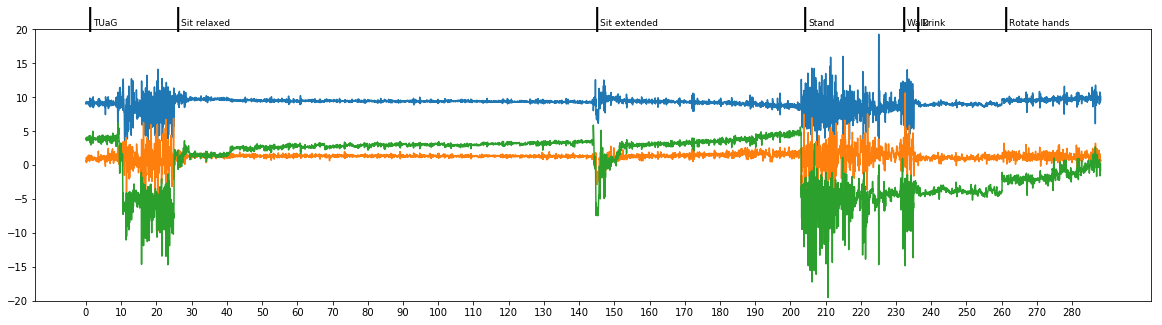



user: 51, assessment: 1490284781631
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 0.26


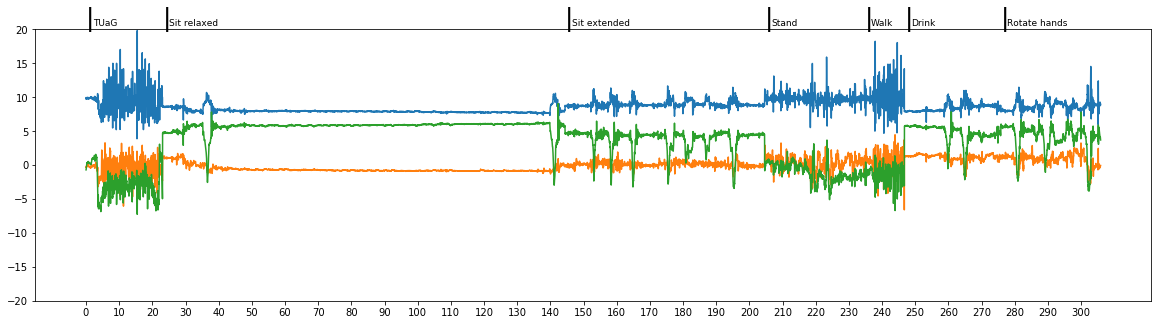

Norm's mean delta from baseline: 0.25


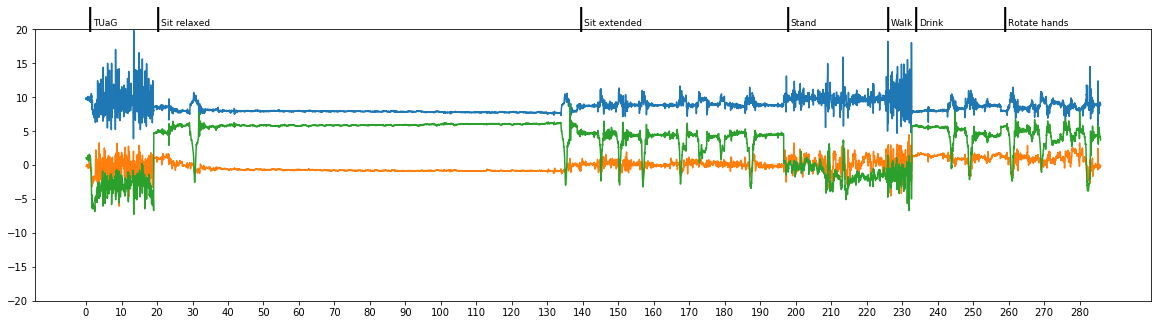



user: 45, assessment: 1490637319938
patient report: 2, clinician report: 3
Norm's mean delta from baseline: 0.53


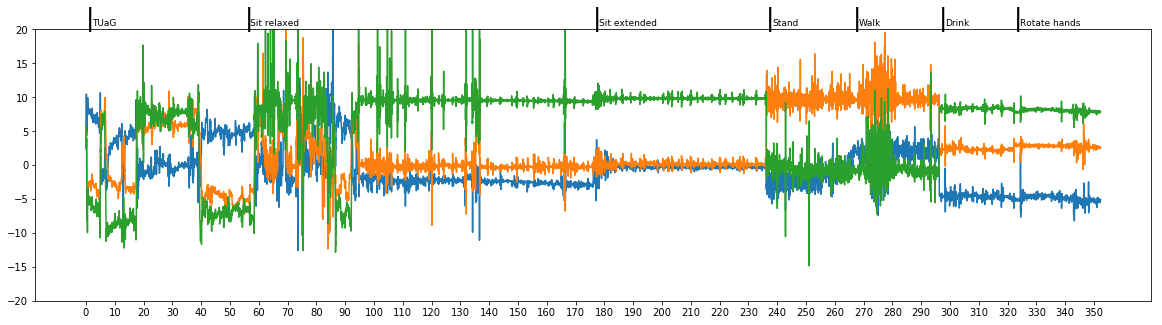

Norm's mean delta from baseline: 0.54


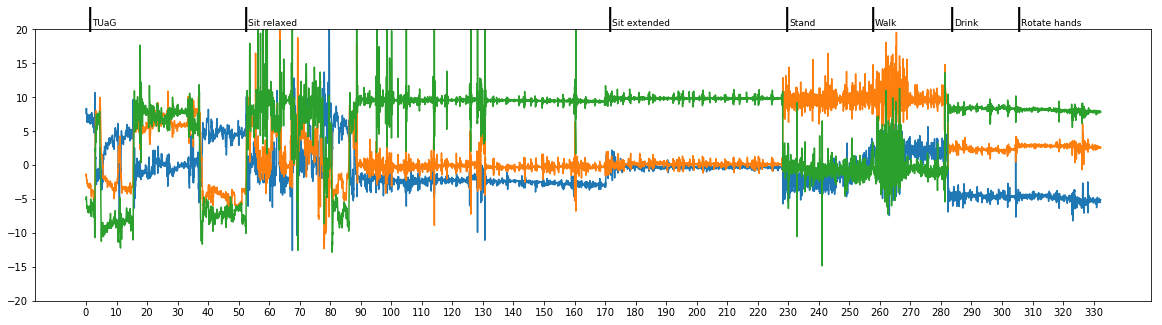



user: 8, assessment: 1490640580656
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 0.22


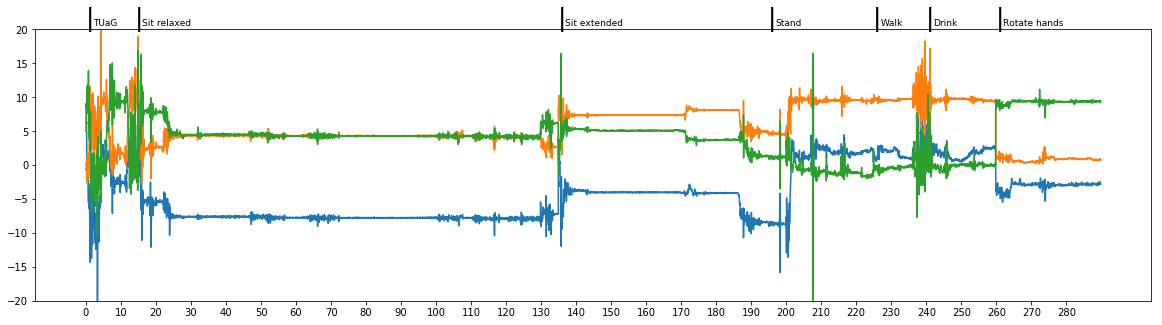

Norm's mean delta from baseline: 0.16


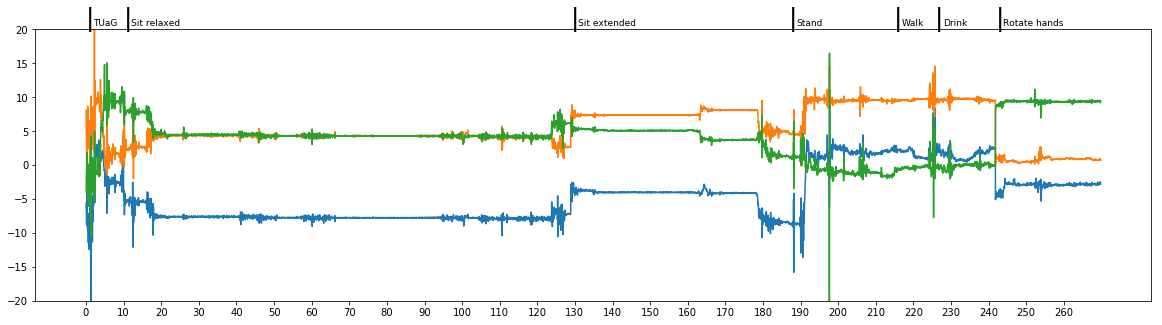



user: 94, assessment: 1493741957038
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 0.14


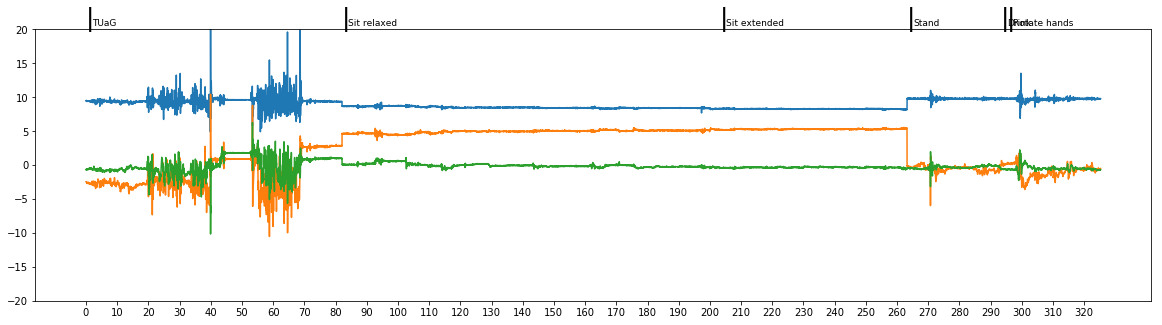

Norm's mean delta from baseline: 0.14


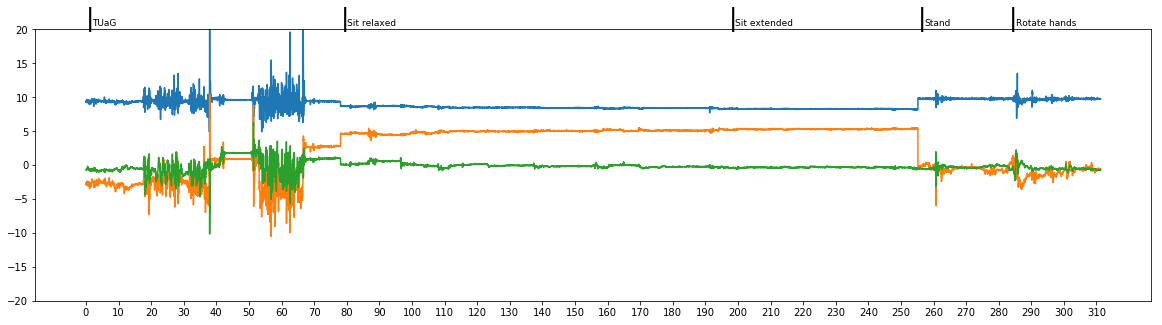



user: 25, assessment: 1493912424448
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 0.19


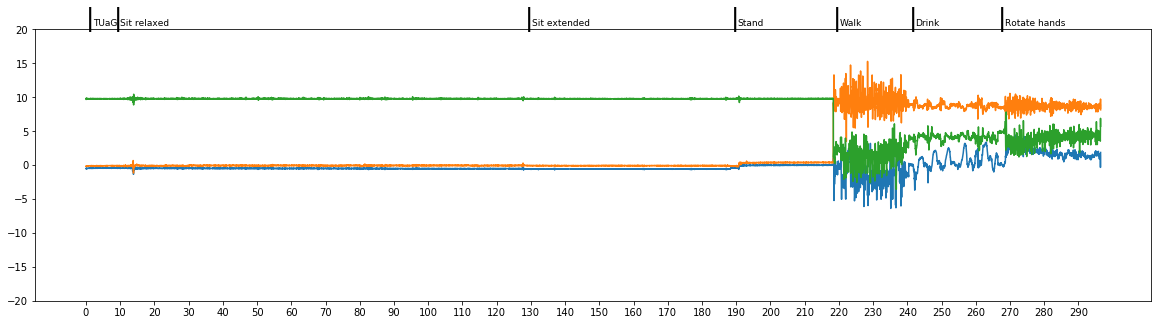

Norm's mean delta from baseline: 0.19


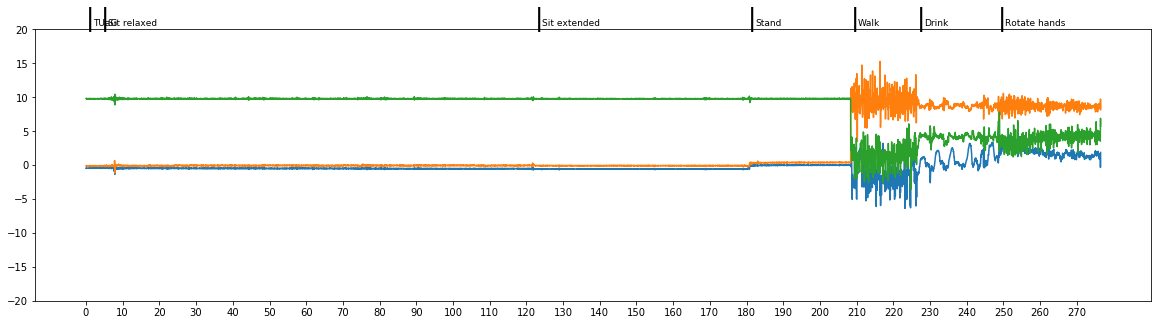



user: 63, assessment: 1493920652116
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 0.20


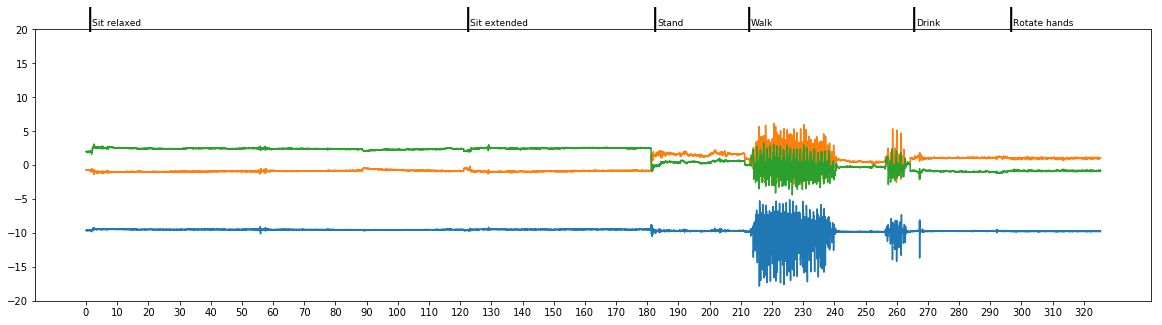

Norm's mean delta from baseline: 0.21


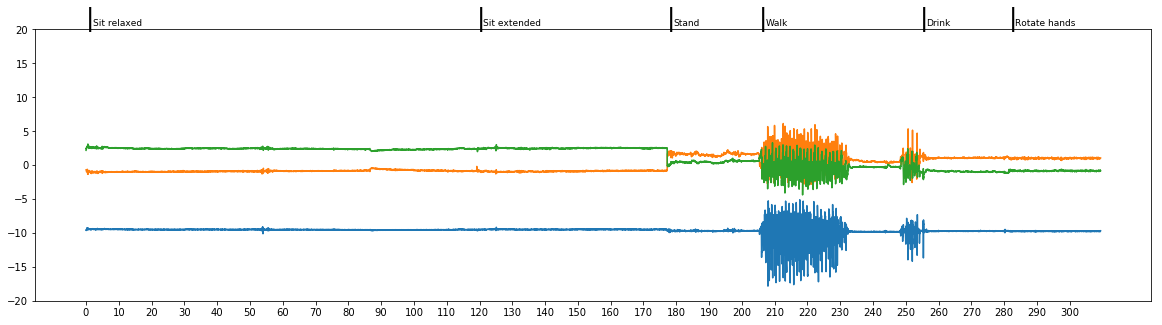

In [119]:
plot_assessment_with_steps(clinic_steps_phone_acc_w_base, 'phone')

In [13]:
clinic_steps_watch_acc_df.head()

user_id  assessment_id        assessment_start          assessment_end  \
0       82  1489765988342 2017-03-17 15:43:54.743 2017-03-17 15:53:08.333   
1       82  1489765988342 2017-03-17 15:43:54.743 2017-03-17 15:53:08.333   
2       82  1489765988342 2017-03-17 15:43:54.743 2017-03-17 15:53:08.333   
3       82  1489765988342 2017-03-17 15:43:54.743 2017-03-17 15:53:08.333   
4       82  1489765988342 2017-03-17 15:43:54.743 2017-03-17 15:53:08.333   

                timestamp    step_name      x     y      z  \
0 2017-03-17 15:45:59.730  Sit relaxed -925.0  49.0 -158.0   
1 2017-03-17 15:45:59.750  Sit relaxed -934.0  17.0 -163.0   
2 2017-03-17 15:45:59.770  Sit relaxed -931.0  -5.0 -150.0   
3 2017-03-17 15:45:59.798  Sit relaxed -916.0   5.0 -144.0   
4 2017-03-17 15:45:59.818  Sit relaxed -924.0  20.0 -151.0   

   patient_report_value  clinician_report_value    acc_norm  acc_abs_delta  
0                   3.0                     4.0  939.675476      60.324524  
1                   3.0                     4.0  948.268949      51.731051  
2                   3.0                     4.0  943.019618      56.980382  
3                   3.0                     4.0  927.263177      72.736823  
4                   3.0                     4.0  936.470501      63.529499

In [37]:
clinic_watch = clinic_steps_watch_acc_df[['user_id', 'assessment_id', 'timestamp', 'patient_report_value',
                                          'clinician_report_value']].sort_values(by=['user_id', 'assessment_id', 'timestamp'])
clinic_watch = clinic_watch[['user_id', 'assessment_id', 'patient_report_value', 'clinician_report_value']]

In [38]:
clinic_watch.drop_duplicates().head()

user_id  assessment_id  patient_report_value  clinician_report_value
32657         8  1490640580656                   1.0                     2.0
134261       25  1487605701264                   1.0                     2.0
87102        25  1493912424448                   0.0                     2.0
31321        45  1490637319938                   2.0                     3.0
123861       51  1490284781631                   3.0                     2.0

In [115]:
sorted_df = clinic_steps_watch_acc_w_base.sort_values(by='timestamp')




patient: 8.0, assessment: 1.49064058066e+12
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 49.117


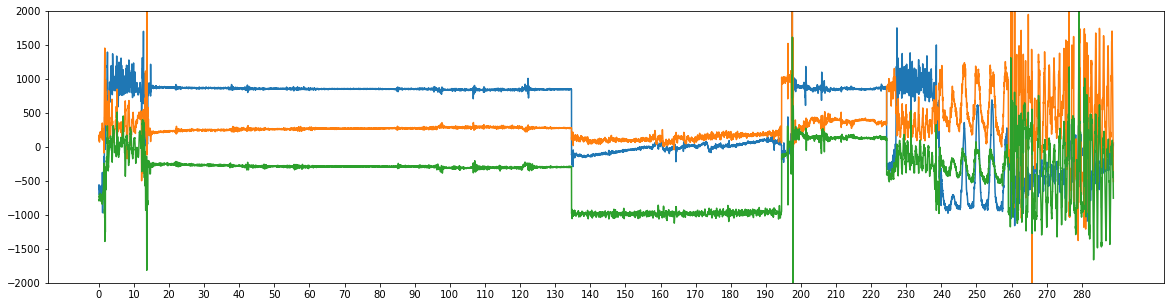




patient: 25.0, assessment: 1.48760570126e+12
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 84.469


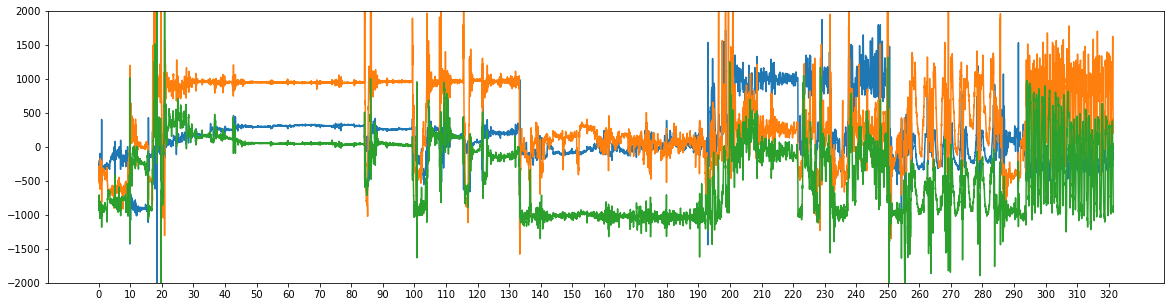




patient: 25.0, assessment: 1.49391242445e+12
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 99.021


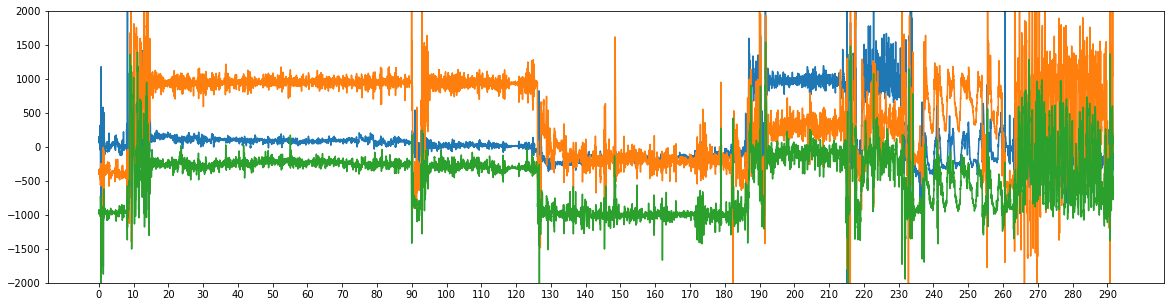




patient: 45.0, assessment: 1.49063731994e+12
patient report: 2, clinician report: 3
Norm's mean delta from baseline: 75.912


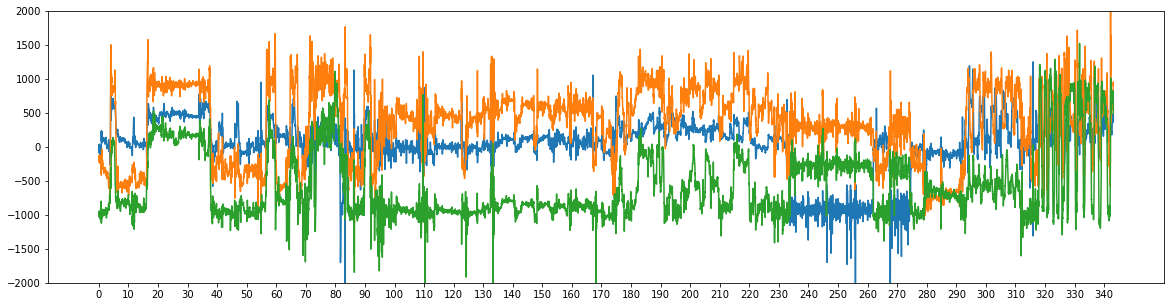




patient: 51.0, assessment: 1.49028478163e+12
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 58.533


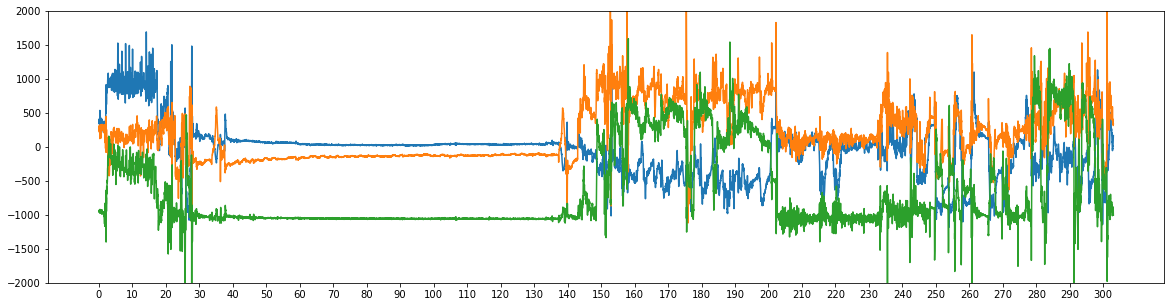




patient: 57.0, assessment: 1.48192323299e+12
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 77.061


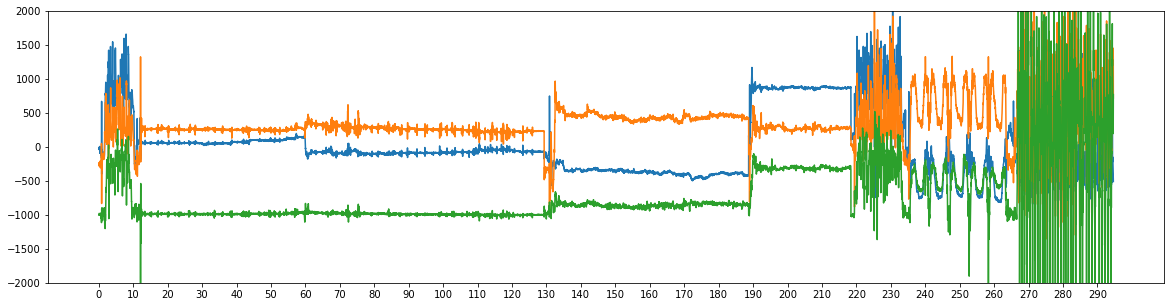




patient: 63.0, assessment: 1.49392065212e+12
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 36.100


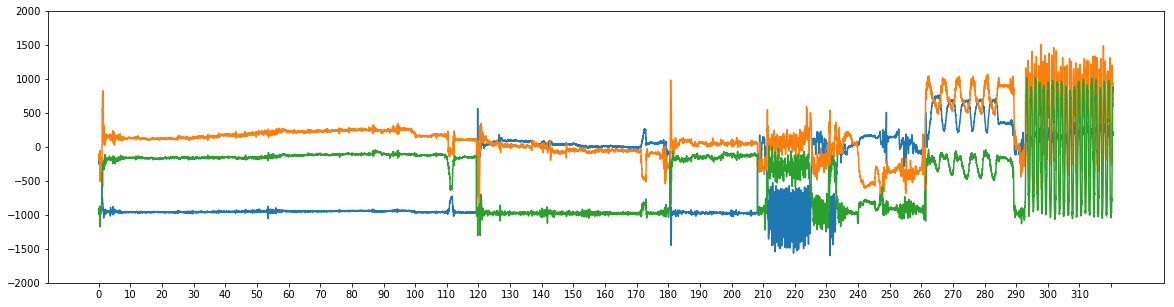




patient: 74.0, assessment: 1.48554632115e+12
patient report: 2, clinician report: 2
Norm's mean delta from baseline: 81.245


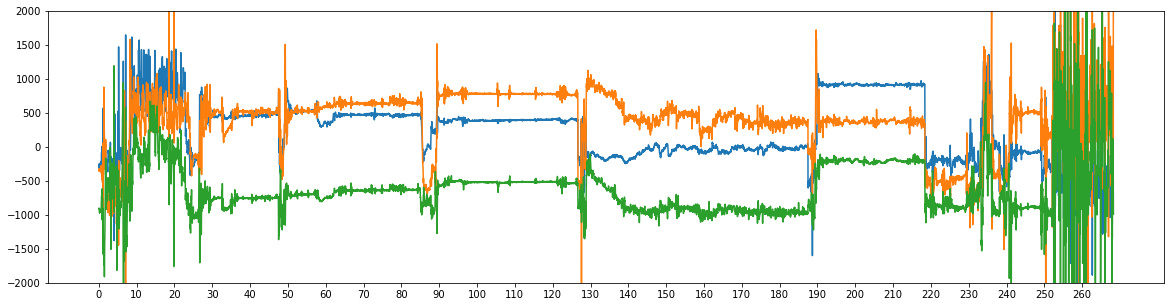




patient: 82.0, assessment: 1.48976598834e+12
patient report: 3, clinician report: 4
Norm's mean delta from baseline: 93.576


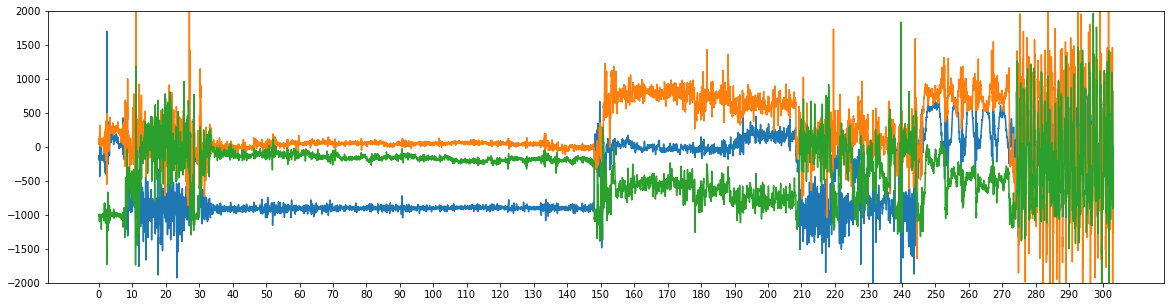




patient: 94.0, assessment: 1.49374195704e+12
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 52.684


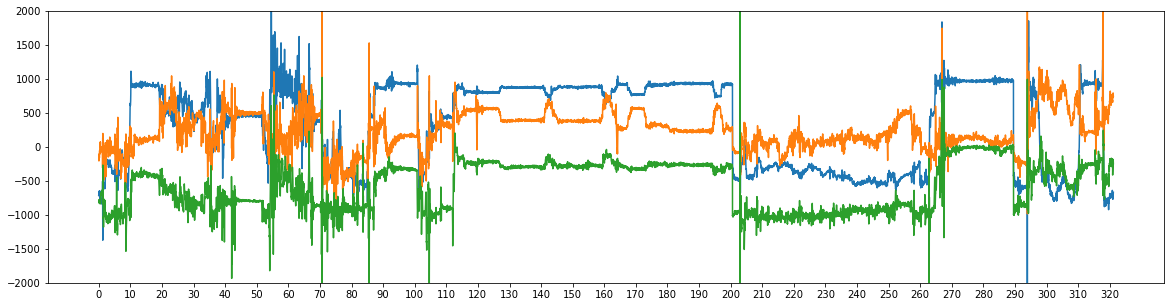




patient: 108.0, assessment: 1.48839618164e+12
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 50.811


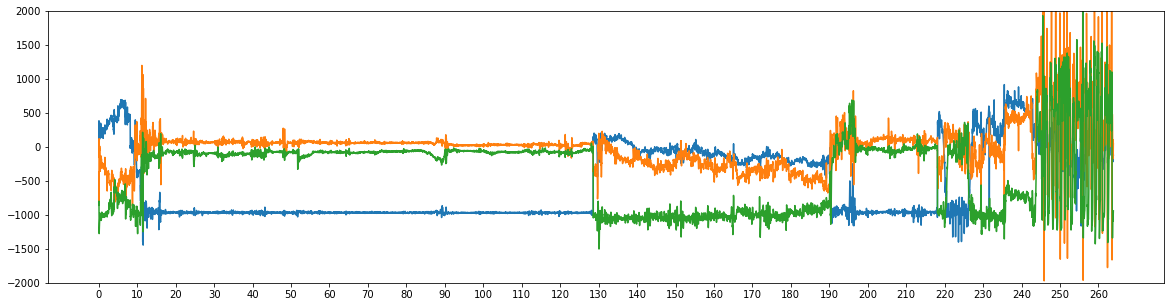

In [121]:
for index, row in clinic_watch.drop_duplicates().iterrows():
    user_id = row['user_id']
    assessment_id = row['assessment_id']
#     step_name = row['step_name']
    patient_report_value = row['patient_report_value']
    clinician_report_value = row['clinician_report_value']
    
    print('\n\n')
    print('patient: %s, assessment: %s' % (user_id, str(assessment_id)))
    print('patient report: %.0f, clinician report: %.0f' % (patient_report_value, clinician_report_value))
    norm_values = sorted_df[['assessment_id', 'acc_abs_delta_user_bl']]\
                  [sorted_df['assessment_id']==assessment_id]
    norm = np.mean(norm_values['acc_abs_delta_user_bl'])
    print("Norm's mean delta from baseline: %.3f" % (norm))
    signal = sorted_df[['x', 'y', 'z']]\
             [sorted_df.assessment_id==assessment_id]
    signal = np.asarray(signal)
    plt.figure(figsize=(20,5))
    plt.plot(signal)
    plt.ylim(-2000, 2000)
    plt.xticks(range(0, signal.shape[0], 500), range(0, int(signal.shape[0]/50), 10))
    plt.show()
    plt.close()




patient: 8.0, assessment: 1.49064058066e+12
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 37.966


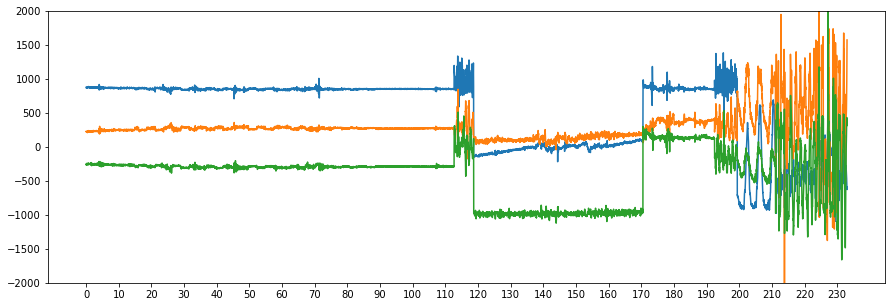




patient: 25.0, assessment: 1.48760570126e+12
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 80.649


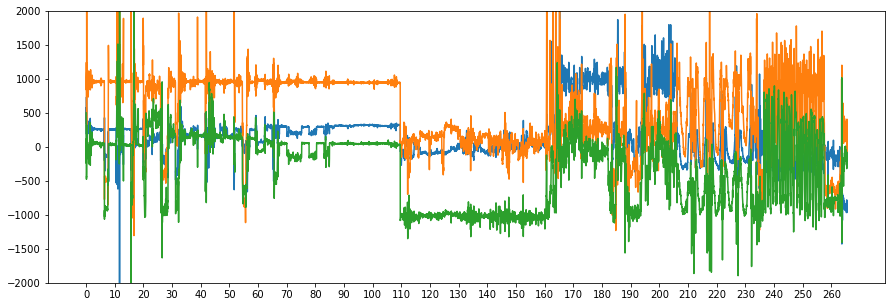




patient: 25.0, assessment: 1.49391242445e+12
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 84.357


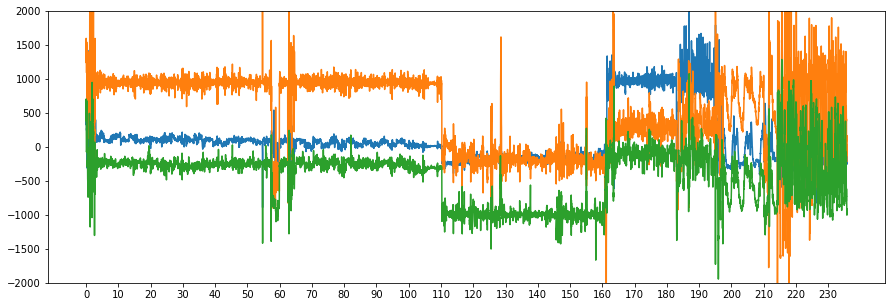




patient: 45.0, assessment: 1.49063731994e+12
patient report: 2, clinician report: 3
Norm's mean delta from baseline: 76.677


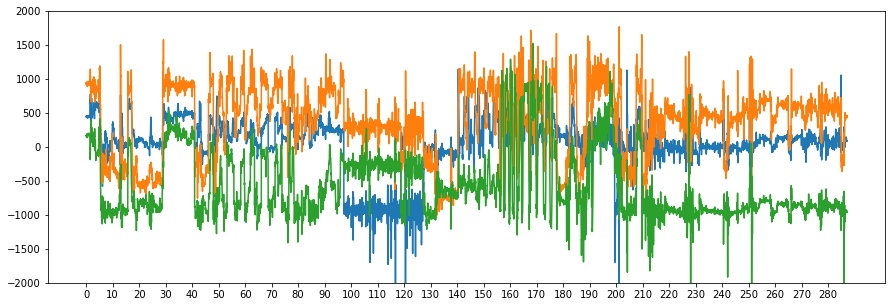




patient: 51.0, assessment: 1.49028478163e+12
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 53.665


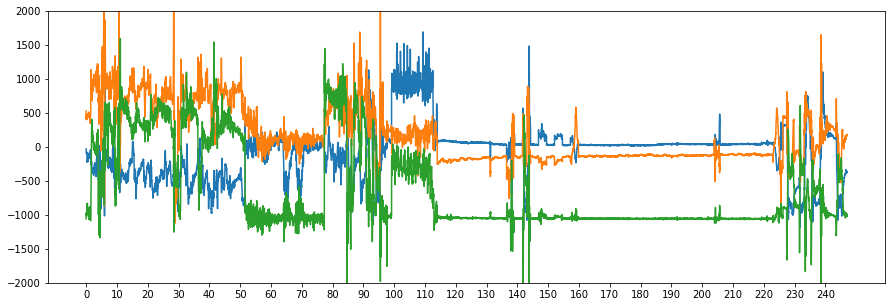




patient: 57.0, assessment: 1.48192323299e+12
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 62.435


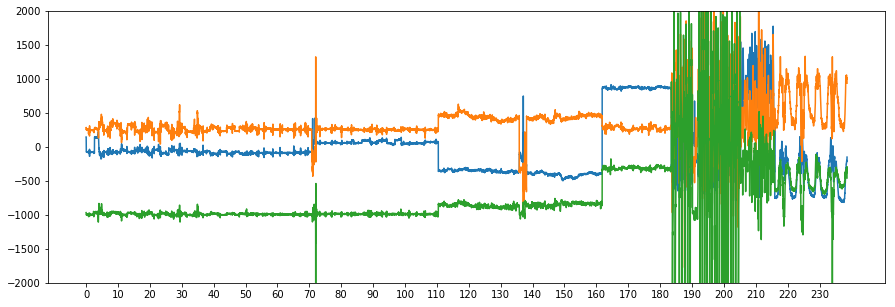




patient: 63.0, assessment: 1.49392065212e+12
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 34.809


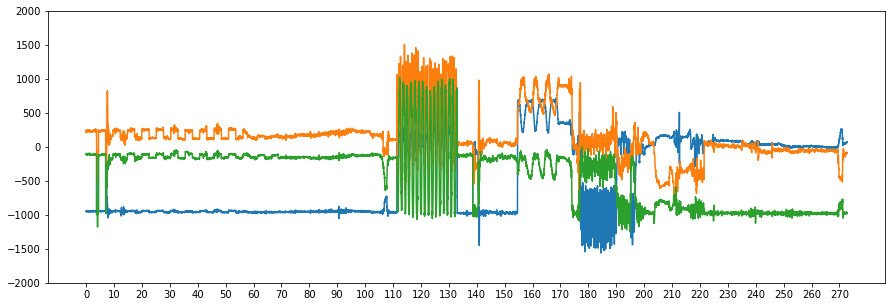




patient: 74.0, assessment: 1.48554632115e+12
patient report: 2, clinician report: 2
Norm's mean delta from baseline: 68.075


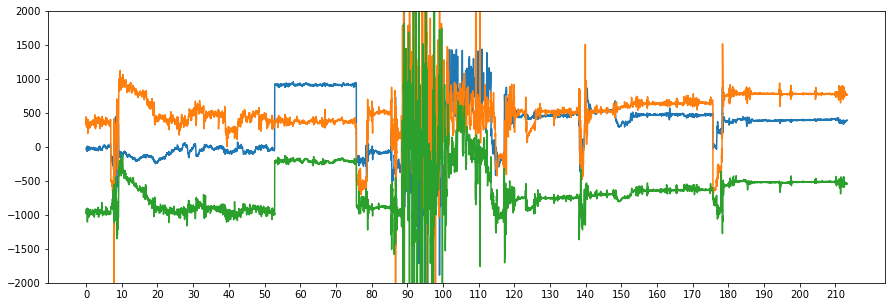




patient: 82.0, assessment: 1.48976598834e+12
patient report: 3, clinician report: 4
Norm's mean delta from baseline: 86.132


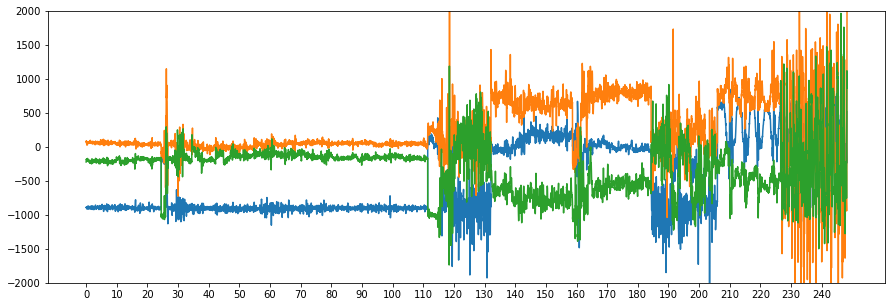




patient: 94.0, assessment: 1.49374195704e+12
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 50.695


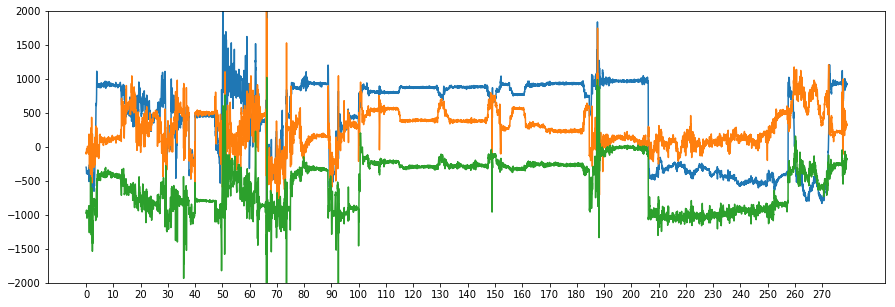




patient: 108.0, assessment: 1.48839618164e+12
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 45.633


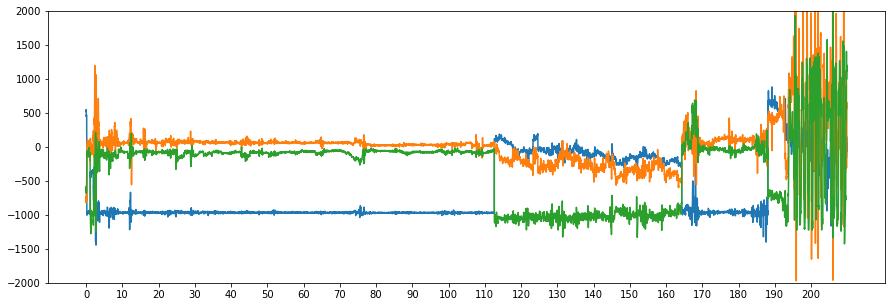

In [46]:
for index, row in clinic_watch.drop_duplicates().iterrows():
    user_id = row['user_id']
    assessment_id = row['assessment_id']
#     step_name = row['step_name']
    patient_report_value = row['patient_report_value']
    clinician_report_value = row['clinician_report_value']
    
    print('\n\n')
    print('patient: %s, assessment: %s' % (user_id, str(assessment_id)))
    print('patient report: %.0f, clinician report: %.0f' % (patient_report_value, clinician_report_value))
    norm_values = trimmed_clinic_steps_watch_acc_w_base[['assessment_id', 'acc_abs_delta_user_bl']]\
                  [trimmed_clinic_steps_watch_acc_w_base['assessment_id']==assessment_id]
    norm = np.mean(norm_values['acc_abs_delta_user_bl'])
    print("Norm's mean delta from baseline: %.3f" % (norm))
    signal = trimmed_clinic_steps_watch_acc_w_base[['x', 'y', 'z']]\
             [trimmed_clinic_steps_watch_acc_w_base.assessment_id==assessment_id]
    signal = np.asarray(signal)
    plt.figure(figsize=(15,5))
    plt.plot(signal)
    plt.ylim(-2000, 2000)
    plt.xticks(range(0, signal.shape[0], 500), range(0, int(signal.shape[0]/50), 10))
    plt.show()
    plt.close()

In [105]:
clinic_phone = clinic_steps_phone_acc_df[['user_id', 'assessment_id', 'step_name', 'patient_report_value', 'clinician_report_value']]\
               .drop_duplicates().sort_values(by=['user_id', 'assessment_id'])




patient: 8, step: Stand
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 0.281


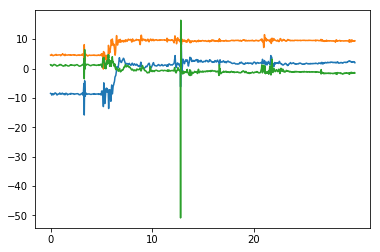




patient: 25, step: Stand
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 0.362


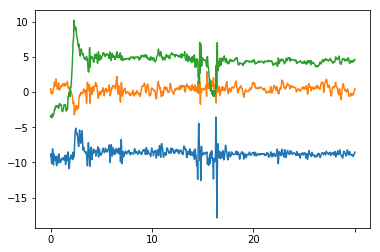




patient: 25, step: Stand
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 0.056


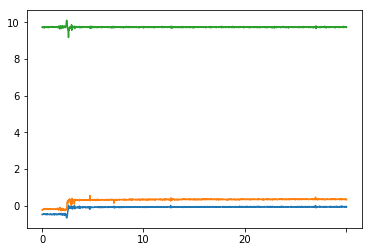




patient: 45, step: Stand
patient report: 2, clinician report: 3
Norm's mean delta from baseline: 0.610


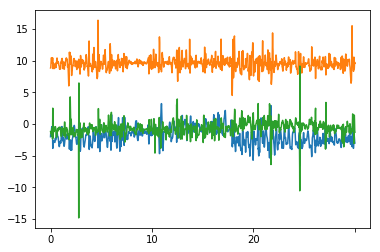




patient: 51, step: Stand
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 0.474


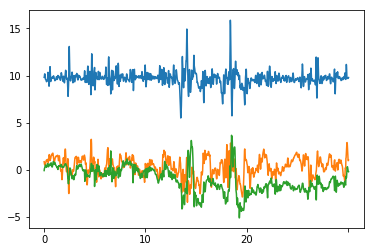




patient: 57, step: Stand
patient report: 1, clinician report: 2
Norm's mean delta from baseline: 0.066


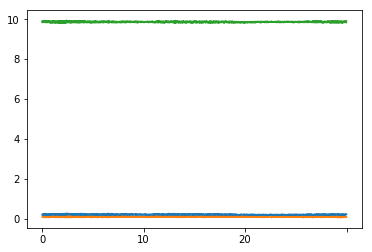




patient: 63, step: Stand
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 0.060


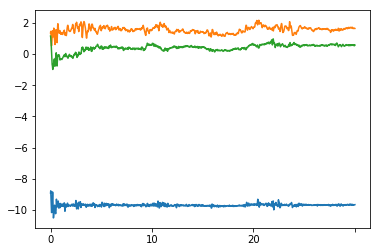




patient: 74, step: Stand
patient report: 2, clinician report: 2
Norm's mean delta from baseline: 0.545


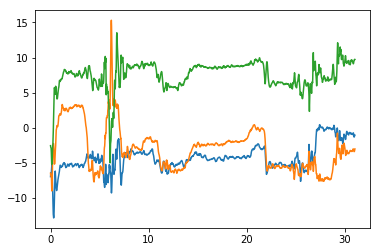




patient: 82, step: Stand
patient report: 3, clinician report: 4
Norm's mean delta from baseline: 1.247


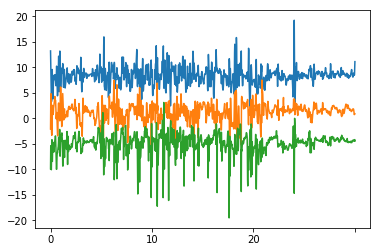




patient: 94, step: Stand
patient report: 3, clinician report: 2
Norm's mean delta from baseline: 0.071


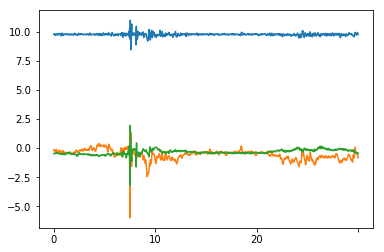




patient: 108, step: Stand
patient report: 0, clinician report: 2
Norm's mean delta from baseline: 0.155


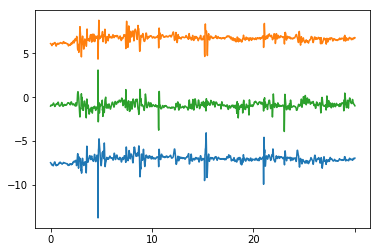

In [108]:
for index, row in clinic_phone.iterrows():
    user_id = row['user_id']
    assessment_id = row['assessment_id']
    step_name = row['step_name']
    patient_report_value = row['patient_report_value']
    clinician_report_value = row['clinician_report_value']

    if step_name=='Stand':
        print('\n\n')
        print('patient: %s, step: %s' % (user_id, step_name))
        print('patient report: %.0f, clinician report: %.0f' % (patient_report_value, clinician_report_value))
        norm_values = clinic_steps_phone_acc_df[['assessment_id', 'step_name', 'acc_abs_delta']]\
                      [(clinic_steps_phone_acc_df['assessment_id']==assessment_id)
                      &(clinic_steps_phone_acc_df['step_name']==step_name)]
        norm = np.mean(norm_values['acc_abs_delta'])
        print("Norm's mean delta from baseline: %.3f" % (norm))
        signal = clinic_steps_phone_acc_df[['x', 'y', 'z']][(clinic_steps_phone_acc_df.assessment_id==assessment_id)\
                                                           &(clinic_steps_phone_acc_df.step_name==step_name)]
        signal = np.asarray(signal)
        plt.figure()
        plt.plot(signal)
    #     plt.ylim(-2000, 2000)
        plt.xticks(range(0, signal.shape[0], 500), range(0, int(signal.shape[0]/50), 10))
        plt.show()
        plt.close()

## Home Raw Data Exploration:

In [8]:
all_home_assessments = home_steps_watch_acc_df.assessment_id.unique().tolist()
home_steps = ['Sit relaxed', 'Stand']




Patient: 51
Patient reported chorea level: 2
Data: home_steps_watch_acc
Step: Sit relaxed
Norm's mean absolute delta: 54.990
len: 5978


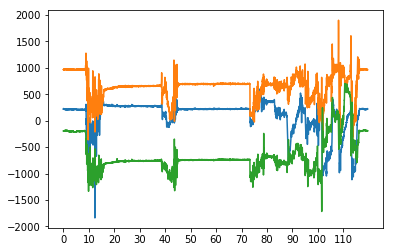

Step: Stand
Norm's mean absolute delta: 68.511
len: 1495


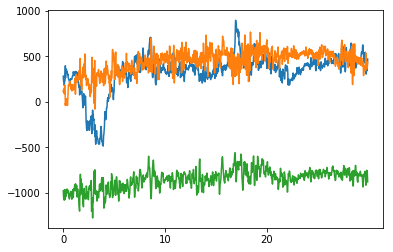

Data: home_steps_phone_acc
Step: Sit relaxed
Norm's mean absolute delta: 0.019
len: 6018


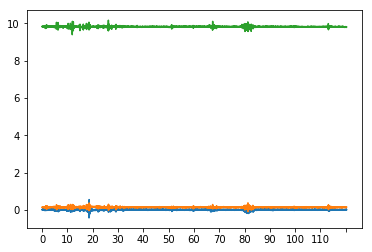

Step: Stand
Norm's mean absolute delta: 0.028
len: 1505


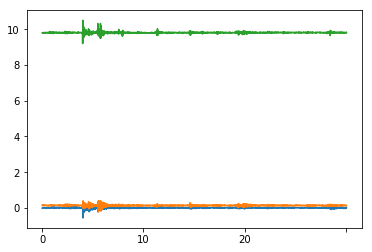




Patient: 57
Patient reported chorea level: 2
Data: home_steps_watch_acc
Step: Sit relaxed
Norm's mean absolute delta: 28.407
len: 5978


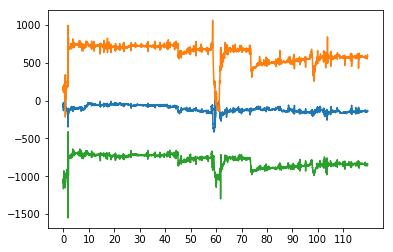

Step: Stand
Norm's mean absolute delta: 40.418
len: 1483


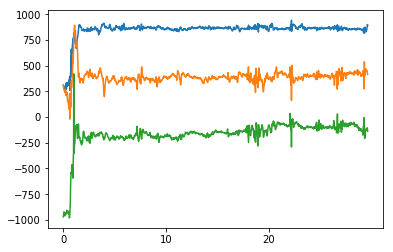

Data: home_steps_phone_acc
Step: Sit relaxed
Norm's mean absolute delta: 0.057
len: 6054


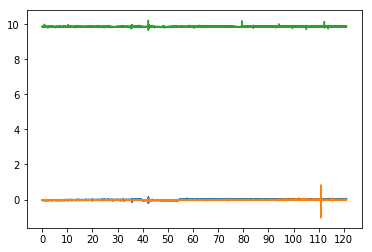

Step: Stand
Norm's mean absolute delta: 0.062
len: 1501


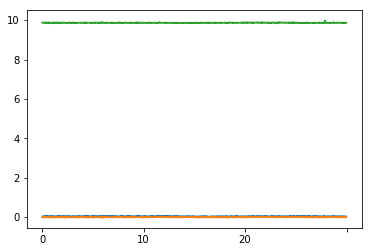




Patient: 51
Patient reported chorea level: 4
Data: home_steps_watch_acc
Step: Sit relaxed
Norm's mean absolute delta: 56.142
len: 6019


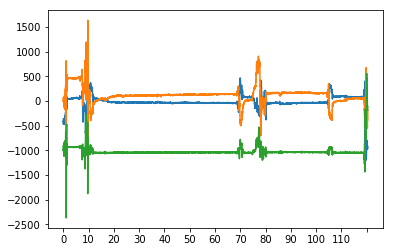

Step: Stand
Norm's mean absolute delta: 121.052
len: 1494


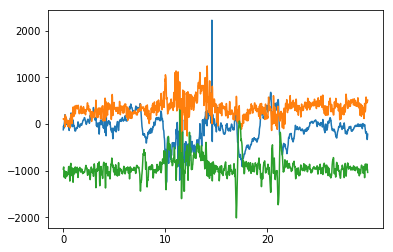

Data: home_steps_phone_acc
Step: Sit relaxed
Norm's mean absolute delta: 0.031
len: 6068


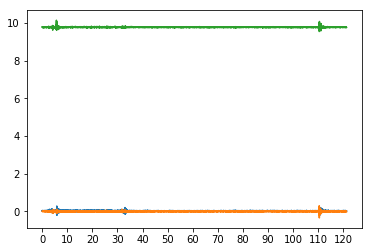

Step: Stand
Norm's mean absolute delta: 0.055
len: 1505


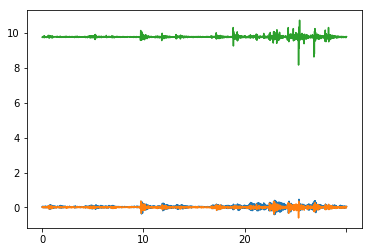




Patient: 45
Patient reported chorea level: 1
Data: home_steps_watch_acc
Step: Sit relaxed
Norm's mean absolute delta: 61.244
len: 5968


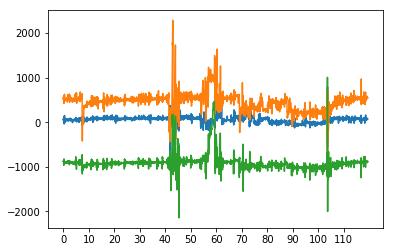

Step: Stand
Norm's mean absolute delta: 72.189
len: 1480


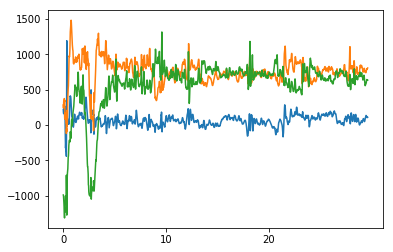

Data: home_steps_phone_acc
Step: Sit relaxed
Norm's mean absolute delta: 0.222
len: 6056


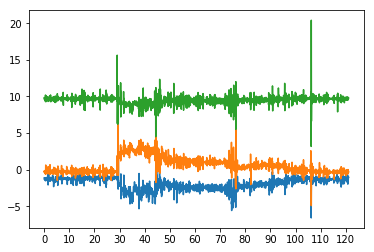

Step: Stand
Norm's mean absolute delta: 0.963
len: 1501


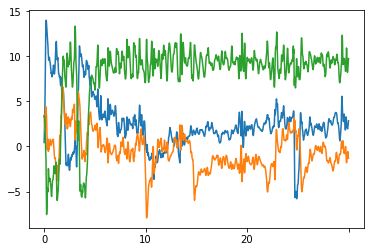




Patient: 57
Patient reported chorea level: 2
Data: home_steps_watch_acc
Step: Sit relaxed
Norm's mean absolute delta: 24.212
len: 5947


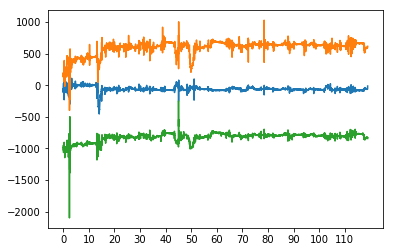

Step: Stand
Norm's mean absolute delta: 42.692
len: 1487


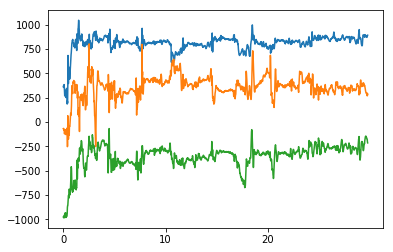

Data: home_steps_phone_acc
Step: Sit relaxed
Norm's mean absolute delta: 0.043
len: 6004


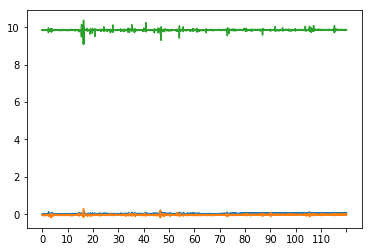

Step: Stand
Norm's mean absolute delta: 0.224
len: 1501


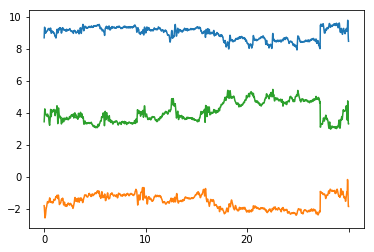

In [16]:
random_assessments = np.random.choice(all_home_assessments, 5, replace = False)
for a in random_assessments:
    single_row = home_steps_watch_acc_df[['user_id', 'assessment_id', 'patient_report_value']]\
                 [home_steps_watch_acc_df.assessment_id==a].drop_duplicates()
    user_id = int(single_row.iloc[0]['user_id'])
    patient_report_value = single_row['patient_report_value']
    print('\n\n')
    print('Patient: %s' % (user_id))
    print('Patient reported chorea level: %.0f' % (patient_report_value))

    for acc_data in [home_steps_watch_acc_df, home_steps_phone_acc_df]:
        print('Data: %s' % (acc_data.name))
        for step in home_steps:
            print('Step: %s' % (step))
            norm_abs_delta = np.mean(acc_data['acc_abs_delta'][(acc_data.assessment_id==a)\
                                                              &(acc_data.step_name==step)])
            print("Norm's mean absolute delta: %.3f" % (norm_abs_delta))
            signal = acc_data[['x', 'y', 'z']][(acc_data.assessment_id==a)\
                                              &(acc_data.step_name==step)]
            signal = np.asarray(signal)
            print('len:', len(signal))
            plt.figure()
            plt.plot(signal)
            plt.xticks(range(0, signal.shape[0], 500), range(0, int(signal.shape[0]/50), 10))

            plt.show()
            plt.close()